<a href="https://colab.research.google.com/github/MarcoFogale/PetitesAnnoncesTraining/blob/main/01_Project_Setup_and_Preliminary_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Capstone Project by Marco Fogale**

## **A Machine Learning Approach to Vehicle Price Prediction in Peer-to-Peer Used Car Sales**

# 01 - Project setup and preliminary exploratory data analysis

## **Introduction**

[Petitesannonces](https://www.petitesannonces.ch) is a well-established peer-to-peer online marketplace for second-hand goods and services, active for over ten years in French-speaking Switzerland. While users can buy, sell, or exchange almost anything on the platform, this study focuses specifically on the second-hand car market.

Unlike other popular platforms—such as [comparis.ch](https://en.comparis.ch/carfinder/vehicleevaluation/create), Petitesannonces lacks a key feature: a car valuation tool. Users who wish to post a used car for sale must manually browse through similar listings to estimate their vehicle’s value. This process is made even more challenging by the volume of listings as over 4,000 car ads are currently on the website.
The aim of this study is to address this gap by proposing a machine learning approach to price prediction.

## **Project's objective: Sale price prediction**

Using data collected from the platform via web scraping, we train a model capable of estimating the market value of a used car based solely on the information typically provided in listings, tailoring the model to the specificity of the market, which is strictly private-to-private and limited to the Romandie region.

#### **Mount Disk and Import Dependencies**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import missingno as msno

import re
from datetime import datetime


## **Preliminary Exploratory Data Analysis (EDA)**

**Objectives**
- Understand the dataset structure
- Assess data quality
- Reveal underlying patterns and trends
- Guide feature engineering and support model strategy

### **Overview of the Dataset**

The website presents the [car section at this link](https://www.petitesannonces.ch/r/1403)

Each car advertisement on Petitesannonces consists of several components:

- A structured table outlining the car's technical specifications
- A free-text field allowing the seller to describe additional details and specific features
- The listed sale price
- A unique reference number identifying the advertisement
- The date of publication

For the purposes of this study, all available advertisements were collected in early July 2025.

The data were stored in a structured CSV file, and all associated images were downloaded and named according to their respective reference numbers.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/_CapstoneProject_/petites_annonces_cars.csv', index_col=0)

In [ ]:
reference_number = 4728028

print('AD DATA: ')
print('')
print('reference number: ', df[df['Numéro de référence:'] == reference_number	].drop_duplicates()['Numéro de référence:'].values[0])
print('published on date: ', df[df['Numéro de référence:'] == reference_number	].drop_duplicates()['Publication:'].values[0])
print('ads kind: ', df[df['Numéro de référence:'] == reference_number	].drop_duplicates()['Type d\'annonce:'].values[0])
print('car model: ', df[df['Numéro de référence:'] == reference_number	].drop_duplicates()['Modèle:'].values[0])
print('year of first registration: ', df[df['Numéro de référence:'] == reference_number	].drop_duplicates()['Année:'].values[0])
print('mileage in km: ', df[df['Numéro de référence:'] == reference_number].drop_duplicates()['Km:'].values[0])
print('transmission type: ', df[df['Numéro de référence:'] == reference_number].drop_duplicates()['Transmission:'].values[0])
print('internal color: ', df[df['Numéro de référence:'] == reference_number].drop_duplicates()['Couleur extérieure:'].values[0])
print('internal color: ', df[df['Numéro de référence:'] == reference_number].drop_duplicates()['Couleur intérieure:'].values[0])
print('fuel kind: ', df[df['Numéro de référence:'] == reference_number].drop_duplicates()['Carburant:'].values[0])
print('')
print('description: ', df[df['Numéro de référence:'] == reference_number].drop_duplicates()['description'].values[0])
print('')
print('sale price: ', df[df['Numéro de référence:'] == reference_number].drop_duplicates()['Prix:'].values[0])

AD DATA: 

reference number:  4728028
published on date:  09.06.2025
ads kind:  nan
car model:  Jaguar XE
year of first registration:  2018
mileage in km:  17'000 km
transmission type:  Automatique
internal color:  Noir (métallisé)
internal color:  Noir (cuir)
fuel kind:  Diesel

description:  Jaguar XE Prestige 180ch 2.0 comme neuve, 17000 km, mise en circulation février 2018. Vente cause changement de véhicule pour raison professionnelle.
Société commerciale ne pas me contacter, merci de respecter. Uniquement contact avec particuliers ou garagiste.


sale price:  32'000.- CHF


#### **Preliminary Operations**

> **Renaming Features**

In [ ]:
df.columns

Index(['Modèle:', 'Année:', 'Km:', 'Prix:', 'Transmission:',
       'Couleur extérieure:', 'Couleur intérieure:', 'Carburant:',
       'description', 'Type d'annonce:', 'Numéro de référence:',
       'Publication:'],
      dtype='object')

In [ ]:
# 1 - Rename Features
new_columns_names = {
    "Type d'annonce:": 'ad_kind',
    'Numéro de référence:': 'reference_number',
    'Publication:':'date_published',
    'Modèle:': 'model',
    'Année:':'year',
    'Km:':'mileage_km',
    'Prix:': 'price',
    'Transmission:' : 'transmission',
    'Couleur extérieure:' : 'external_color',
    'Couleur intérieure:' : 'internal_color',
    'Carburant:' : 'fuel'
}
df.rename(columns=new_columns_names, inplace=True)

> **Checking for duplicates**

In [ ]:
print('dataset shape: ', df.shape)
df.head(5)

dataset shape:  (7957, 12)


,model,year,mileage_km,price,transmission,external_color,internal_color,fuel,description,ad_kind,reference_number,date_published
0,Porsche S,2013,107'000 km,--,Séquentielle,Blanc (métallisé),Anthracite (cuir),Diesel,4 jantes neuves 10'5 / 295x35x22'\n( 7'700.-)\...,Premium,8068202,20.06.2025
1,Porsche S,2013,107'000 km,--,Séquentielle,Blanc (métallisé),Anthracite (cuir),Diesel,4 jantes neuves 10'5 / 295x35x22'\n( 7'700.-)\...,Premium,8068202,20.06.2025
2,Porsche S,2013,107'000 km,--,Séquentielle,Blanc (métallisé),Anthracite (cuir),Diesel,4 jantes neuves 10'5 / 295x35x22'\n( 7'700.-)\...,Premium,8068202,20.06.2025
3,Porsche S,2013,107'000 km,--,Séquentielle,Blanc (métallisé),Anthracite (cuir),Diesel,4 jantes neuves 10'5 / 295x35x22'\n( 7'700.-)\...,Premium,8068202,20.06.2025
4,Toyota Yaris 1.0,2000,135'000 km,2'950.- CHF,Manuelle,Blanc,Gris,Essence,Toyota Yaris 1.0 à vendre dans les plus bref d...,Premium,8068126,20.06.2025


In [ ]:
# 2 - Drop Duplicates
df.drop_duplicates(inplace= True)

In [ ]:
print(df.shape)

(3999, 12)


<b>Observation</b><br>
The website hosts over 4000 listings. Although this represents a substantial dataset, its size does not warrant the use of a dedicated database for storage; instead, the entire training process can be efficiently conducted using a CSV file.

Given the limited control over the accuracy of the data—despite its structured format on the website, there is a risk of misclassification (e.g., listings unrelated to car sales appearing in the car category). Therefore, particular attention will be devoted to data cleaning and preprocessing to ensure data quality.

In addition, certain features will require appropriate encoding techniques, such as one-hot or integer encoding. Depending on the selected model, further preprocessing steps, such as feature scaling, may also be necessary.

> **Resetting Index**

In [ ]:
# 3 - Reset Index
df.set_index('reference_number', inplace=True)

> **Checking for Missing Values**

Number of missing values in each column:
model                0
year                 0
mileage_km           0
price                0
transmission         0
external_color       0
internal_color       0
fuel                 0
description          0
ad_kind           3993
date_published       0
dtype: int64


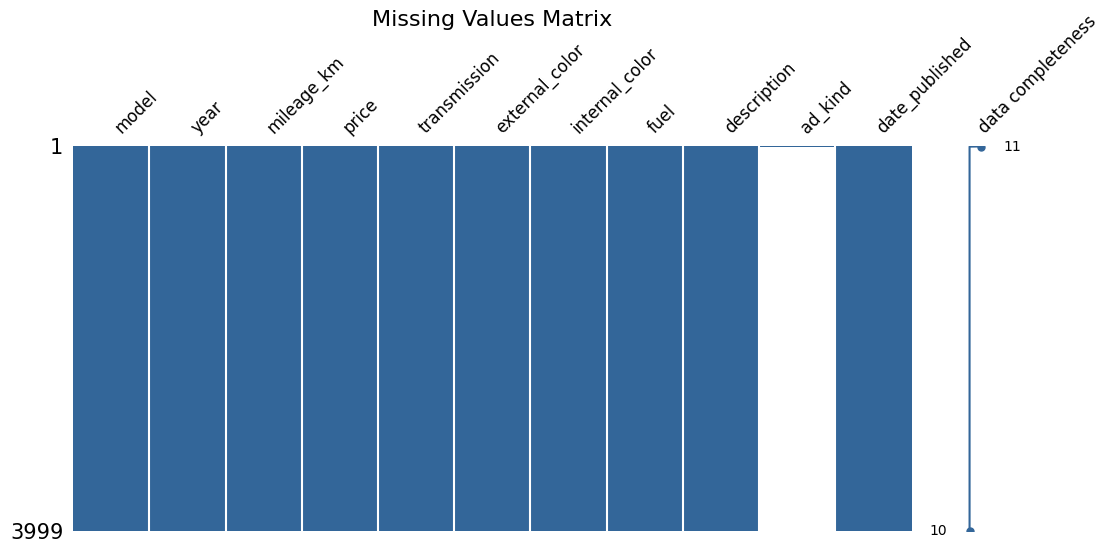

In [ ]:
print('Number of missing values in each column:')
print(df.isnull().sum())

msno.matrix(df, figsize=(12, 5), fontsize=12, labels=True, color=(0.2, 0.4, 0.6))
plt.title('Missing Values Matrix', fontsize=16)
plt.show()

<b>Observation</b></br>
All columns contain no missing values, except for the "ad_kind" feature.\
This suggests that only a small proportion of users opt for the paid "premium" advertisement, while the vast majority prefer the free option.

<b>Decision</b></br>
The ad_kind can't add enough value from a statistical point of view to train a machine learning model and will be dropped

In [ ]:
# 4 - Drop ad_kind feature
df.drop(columns=['ad_kind'], inplace=True)

### **Explore Target Variable**

> **Checking type and printing samples**

In [ ]:
print(df.price.dtype)
print(df.sort_values(by='price', ascending=False).price.head(5))
print(df.sort_values(by='price', ascending=False).price.tail(5))

object
reference_number
7753470       999.- CHF
2829812       990.- CHF
3837311       990.- CHF
8046337    99'500.- CHF
6151600       987.- CHF
Name: price, dtype: object
reference_number
7778188    --
7938860    --
7775332    --
7672697    --
8068202    --
Name: price, dtype: object


<b>Observation</b></br>
The column contains string characters that need to be removed. It also contain invalid characteres where the feature should just display null values.

<b>Decision</b></br>
Data cleaning operations are necessary in order to get a clean, integer value for the target variable

In [ ]:
# 1 - remove literal characters from the price column
df.price = df.price.apply(lambda x: str(x).replace("'",'').replace('CHF', '').strip().removesuffix('.-'))

# check for invalid values in the price column
invalid_values = df[~df['price'].apply(lambda x: str(x).isdigit())]['price']
print(f'Invalid values still present: {invalid_values.unique()}')
print(f"Number of rows with invalid values: {df[~df['price'].apply(lambda x: str(x).isdigit())].shape[0]}")
print(f"Percentage of rows with missing target variable: {df[~df['price'].apply(lambda x: str(x).isdigit())].shape[0] / df.shape[0] * 100:.2f}%")

# 2 - remove invalid values
df = df[df['price'].apply(lambda x: str(x).isdigit())].copy()

# 3 - cast to integer
df.price = df.price.astype('int')
print('After cleaning, the dataset shape is: ', df.shape)

Invalid values still present: ['--']
Number of rows with invalid values: 105
Percentage of rows with missing target variable: 2.63%
After cleaning, the dataset shape is:  (3894, 10)


> **Analysing target variable: statistics, min-max value samples and distribution**

In [ ]:
print(df.price.describe())

count      3894.000000
mean      14739.633539
std       16707.646139
min           0.000000
25%        4300.000000
50%        9500.000000
75%       19500.000000
max      330000.000000
Name: price, dtype: float64


In [ ]:
print('Most expensive cars data:')
df[df.price > 100000].sort_values(by='price', ascending= False)

Most expensive cars data:


,model,year,mileage_km,price,transmission,external_color,internal_color,fuel,description,date_published
reference_number,,,,,,,,,,
7758796,Autres De Tomaso Mangusta,1969,50'000 km,330000,Manuelle,Rouge,Anthracite (cuir),Essence,1 sur 401 productions\n50'000 kilomètres\nDesi...,22.06.2025
7669221,Autres AC Cobra 427 S/C,1966,20'000 km,230000,Manuelle,Rouge,Anthracite (cuir),Essence,Moteur V8 FORD 289Ci 500CV de 1965\nBoite de v...,22.06.2025
8046974,Mercedes-benz A45 AMG,2016,195'000 km,190000,Automatique,Gris (métallisé),Noir (cuir),Essence,Vend Mercedes A45 AMG année 2016 full option\n...,05.06.2025
8030423,BMW M5 Berline G90,2025,3'500 km,145000,Séquentielle,Noir (métallisé),Noir (cuir),Essence,"BMW M5 Berline G90 noir mat, jantes noirs.\nFé...",24.06.2025
7021676,Ferrari F430,2006,70'000 km,135000,Séquentielle,Rouge (métallisé),Noir (cuir),Essence,Spider F1\nExpertisée (2021)\nCollecteur d'éch...,03.06.2025
8055420,Porsche 911 Carrera,2024,16'000 km,131900,Séquentielle,Gris (métallisé),Rouge (cuir),Essence,Assistant de changement de voie\nBOSE® Surroun...,11.06.2025
7446156,Porsche Cabrio 911.1 - 4 GTS PDK,2015,31'100 km,129000,Séquentielle,Anthracite (métallisé),Noir (cuir),Essence,Immaculate Carrera 4 GTS with the naturally as...,24.06.2025
7117897,Audi R8 V10 Sportec 600CV,2010,49'000 km,115000,Manuelle,Blanc,Noir (cuir),Essence,"Rarissime Audi R8 V10 manuelle, informations s...",17.06.2025
3432603,Autres LOLA T490B,1978,20 km,111000,Manuelle,Rouge,Argent,Essence,Voiture de course construite à un seul exempla...,05.06.2025


In [ ]:
print('Less expensive cars data:')
print(f'Number of samples with price lower than 500 CHF: {df[df.price < 500].shape[0]}')
print(f"Percentage of rows with price lower than 500 CHF: {df[df['price']< 500].shape[0] / df.shape[0] * 100:.2f}%")
display(df[df.price < 50].sort_values(by='price', ascending= False))

Less expensive cars data:
Number of samples with price lower than 500 CHF: 76
Percentage of rows with price lower than 500 CHF: 1.95%


,model,year,mileage_km,price,transmission,external_color,internal_color,fuel,description,date_published
reference_number,,,,,,,,,,
7703524,Citroën Location C4 Auto,2005,180'000 km,49,Automatique,Rouge (métallisé),Anthracite (cuir),Essence,- Pas de Caution\n- Km illimité\n49.- CHF la j...,12.06.2025
5164550,Nissan Qashqai,2011,4'000 km,40,Manuelle,Anthracite (métallisé),Anthracite (cuir),Diesel,Voiture 4X4 à louer pour une escapade ou autre...,17.06.2025
4673016,Honda Jazz,2009,130'000 km,35,Manuelle,Gris (métallisé),Anthracite,Essence,Location Honda Jazz vehicule économique\n1 jou...,28.06.2025
7978693,Ford Ka 1.3,2007,350'000 km,30,Manuelle,Gris (métallisé),Anthracite,Essence,Joint de culasse à refaire.\n,19.06.2025
7553410,Smart Fortwo,2005,130'000 km,25,Automatique,Anthracite (métallisé),Anthracite (cuir),Essence,Location de ma Smart\n1 jour 25.-\nUne semaine...,04.06.2025
4672995,Toyota Aygo,2006,200'000 km,20,Manuelle,Rouge (métallisé),Anthracite,Essence,Location\nToyota Aygo 1 litre sans caution\n20...,28.06.2025
7849929,Audi A4,2024,1'000 km,10,Automatique,Anthracite (métallisé),Anthracite (cuir),Essence,"Je vends de l'huile de frein Castrol DOT 4, qu...",22.06.2025
6781471,BMW 120D,2013,10'000 km,10,Automatique,Noir (métallisé),Anthracite (cuir),Diesel,ORIGINAL BMW\nje vends un porte documents form...,10.06.2025
7368515,Autres Achat de voitures,2003,250'000 km,9,Manuelle,Anthracite (métallisé),Anthracite (cuir),Essence,"Bonjour, si vous désirez vendre votre véhicule...",02.06.2025


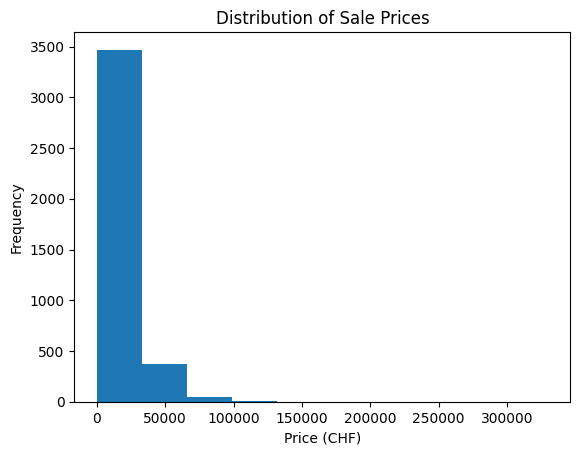

In [ ]:
ax, fig = plt.subplots()
plt.hist(df.price)
plt.title('Distribution of Sale Prices')
plt.xlabel('Price (CHF)')
plt.ylabel('Frequency')
plt.show()

<b>Observation</b></br>
The distribution of prices is left-skewed, primarily due to a small number of entries representing luxury vehicles with exceptionally high prices. <br>
These cases are considered outliers but are not erroneous. On the opposite end, fewer than 2% of the entries fall outside the intended scope of this study. These include advertisements for vehicles offered for free, at a symbolic price (e.g., 1 CHF), or from car rental services.

<b>Decision</b><br>
To enhance data relevance, we will exclude all advertisements with a listed price below 500 CHF, as these are likely to represent rental offers, leasing options, or vehicle parts rather than standard sales.<br> Additionally, we will attempt to remove remaining irrelevant ads, potentially above the 500 CHF threshold, by filtering entries that contain keywords commonly associated with rental services. <br>To address the skewness of the target variable and improve the performance of predictive models, we will also apply a logarithmic transformation to the price variable.

In [ ]:
# 4 - remove rows with price lower than 500 CHF
df = df[df.price >= 500]

# 5 - remove rows with specific keywords in the description
df = df[~df.description.str.upper().str.contains('LOCATION')]
df = df[~df.description.str.upper().str.contains('LOUER')]
df = df[~df.description.str.upper().str.contains('LOUEZ')]
df = df[~((df.description.str.upper().str.contains('LEASE')) & (df.price < 2000))]

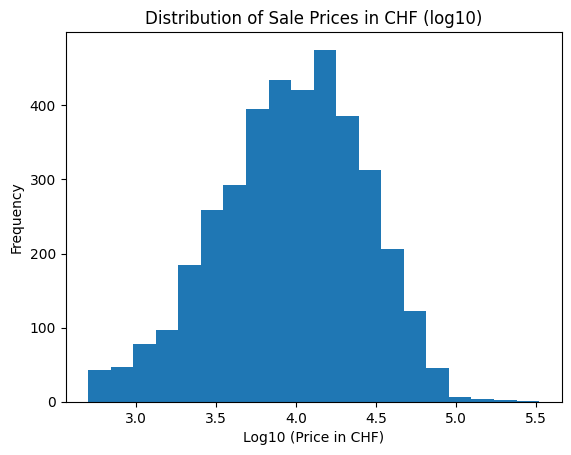

Datset shape after removing irrelevant ads: (3811, 10)


In [ ]:
fig, ax = plt.subplots()
ax.hist(np.log10(df['price']), bins=20)
ax.set_title('Distribution of Sale Prices in CHF (log10)')
ax.set_xlabel('Log10 (Price in CHF)')
ax.set_ylabel('Frequency')
plt.show()

print(f'Datset shape after removing irrelevant ads: {df.shape}')

In [ ]:
# 6 - Applying a logarithmic transformation to the target variable
df.price = np.log10(df.price)

<b>Conclusion</b><br>
The distribution of the target variable now approximates a normal distribution. This transformation is essential, as it helps satisfy one of the key assumptions underlying linear models such as linear regression and ridge regression.

Although erroneous entries have been removed, the dataset remains sufficiently large to support the application of machine learning algorithms.

### **Analysis of Numeric Features**

#### **Exploring the mileage in kilometers feature**

> **Checking type and printing samples**

In [ ]:
print(df.mileage_km.dtype)
print(df.mileage_km.sample(5))
print(df.sort_values(by='mileage_km').mileage_km.head(5))
print(df.sort_values(by='mileage_km').mileage_km.tail(5))

object
reference_number
5356825     55'000 km
6966200     65'000 km
8076606    239'000 km
5198998     74'000 km
5061928    138'000 km
Name: mileage_km, dtype: object
reference_number
7430865    --
7101717    --
6105664    --
6846800    --
6703502    --
Name: mileage_km, dtype: object
reference_number
4528606     99'900 km
7692343     99'900 km
5065959    999'999 km
7849510    999'999 km
3941169    999'999 km
Name: mileage_km, dtype: object


<b>Observation</b><br>
Similarly to the target variable, other numeric features contain literal characters and need a data cleaning operation

<b>Decision</b><br>
Removing string characters and cast the feature into integer data type

In [ ]:
# 1 - cleaning mileage feature from invalid chars and cast it to integer
df.mileage_km = df['mileage_km'].apply(lambda x: str(x).replace("'",'').replace('km', '').replace('--','').strip())
df = df[df['mileage_km'].apply(lambda x: str(x).isdigit())].copy()
df.mileage_km = df.mileage_km.astype('int')

> **Analyzing mileage statistics and its relationship with the mileage and the sale price**

In [ ]:
df.mileage_km.describe()

,mileage_km
count,3800.000000
mean,127681.465789
std,77508.748202
min,1.000000
25%,73375.000000
50%,120455.000000
75%,171532.000000
max,999999.000000


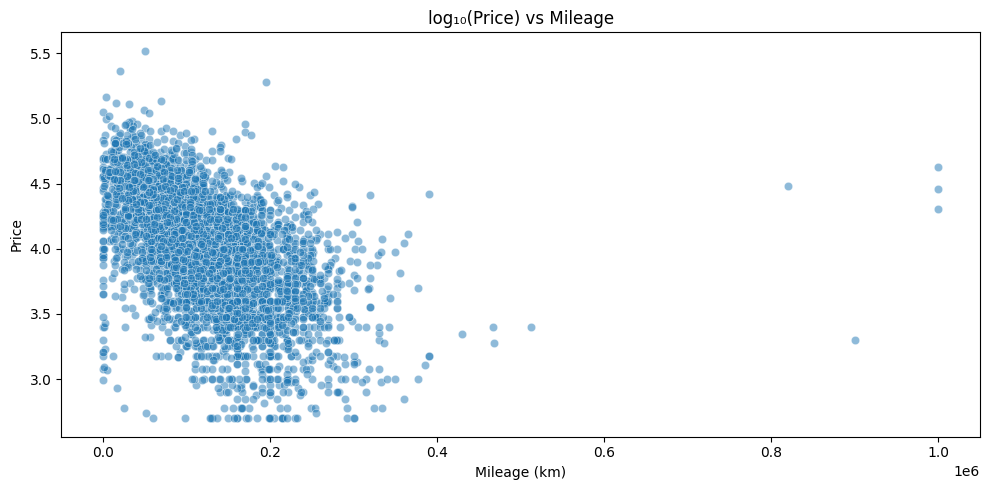

 
Displaying the top 8 cars by mileage:


,model,year,mileage_km,price,transmission,external_color,internal_color,fuel,description,date_published
reference_number,,,,,,,,,,
7849510,VW Rachat voiture cash,2010,999999,4.301008,Manuelle,Anthracite (métallisé),Anthracite (cuir),Essence,0787662045\n0787662045\n0787662045\nEntreprise...,12.06.2025
3941169,Ford Torino GT,1971,999999,4.454845,Automatique,Blanc,Anthracite,Essence,Vendons une très sympa Ford Torino GT 500 de 1...,04.06.2025
5065959,Buick Riviera boattail 455,1971,999999,4.628389,Automatique,Bordeaux (métallisé),Blanc,Essence,Vendons à regrêt notre '71 Buick Riviera Boatt...,04.06.2025
3445034,Opel Astra,1996,900700,3.301030,Manuelle,Rouge (métallisé),Noir,Essence,Je vend voiture opel astra année 1996 expérien...,12.06.2025
4599743,Mercedes-benz A 45 AMG,2014,820000,4.484300,Automatique,Noir (métallisé),Noir (cuir),Essence,Voiture bonne état\n,30.05.2025
4073442,Mercedes-benz E 270 break,2002,512000,3.397940,Automatique,Gris (métallisé),Noir (cuir),Diesel,"Mercedes-Benz E270 break CDI, toit ouvrant Véh...",16.06.2025
6600828,Citroën Saxo,2003,468000,3.278754,Manuelle,Bleu (métallisé),Noir,Essence,Expertisée\nAucun frais à prévoir\nTrès bien e...,02.06.2025
7745703,BMW E46 330d phase 1 de 2000,2000,467000,3.397940,Manuelle,Gris (métallisé),Gris,Diesel,BMW 330d E46 phase 1 de 2000 à vendre\n~467'00...,10.06.2025


In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='mileage_km', y=df['price'], alpha=0.5)

plt.title("log₁₀(Price) vs Mileage")
plt.xlabel("Mileage (km)")
plt.ylabel("Price")
plt.tight_layout()
plt.show()
print(' ')
print('Displaying the top 8 cars by mileage:')
display(df.sort_values(by='mileage_km', ascending=False).head(8))

<b>Observation</b><br>
We observed the presence of unusually high values in the mileage field, such as 999999 km. The first two such entries appear to be erroneous, likely the result of a mandatory mileage field being filled with an arbitrary high number. Additionally, the fourth entry—a Mercedes-Benz A-Class—has a mileage and price combination that seems implausible given the vehicle type and condition, suggesting a likely input error.

<b>Decision</b><br>
To address these anomalies, we decided to cap the mileage at a maximum of 450,000 km. While this is still a very high mileage, it remains within the bounds of plausibility.

In [ ]:
# 2 - remove rows with mileage higher than 450000 km
mileage_threshold = 450000
df = df[df['mileage_km'] <= mileage_threshold]

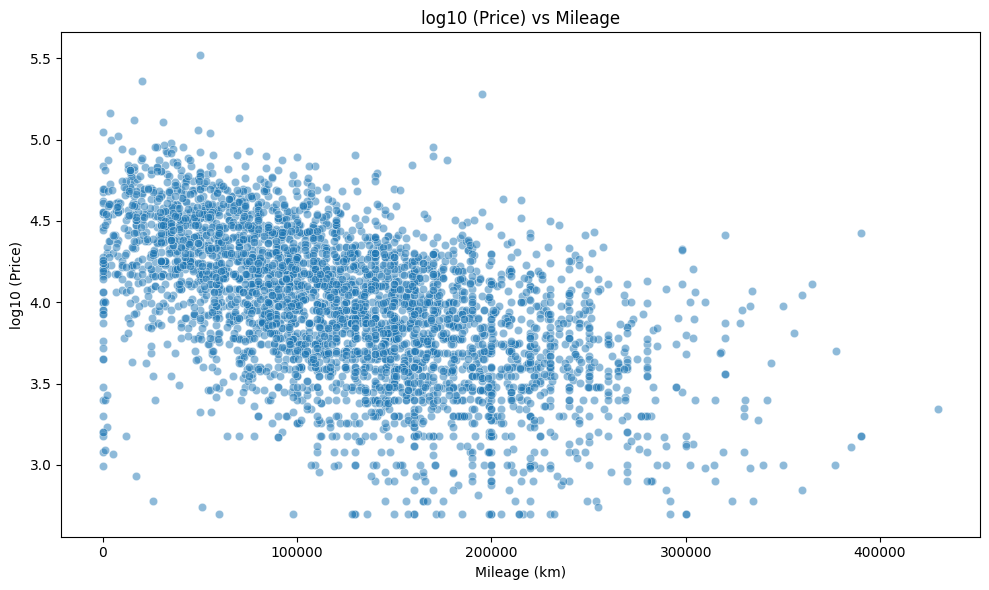

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='mileage_km', y=df['price'], alpha=0.5)

plt.title("log10 (Price) vs Mileage")
plt.xlabel("Mileage (km)")
plt.ylabel("log10 (Price)")
plt.tight_layout()
plt.show()

> **Assessing the correlation with the target variable**

In [ ]:
corr = df['mileage_km'].corr(df['price'])
print(f"Correlation between mileage_km and price: {corr:.3f}")

Correlation between mileage_km and price: -0.537


<b>Conclusion</b><br>
A linear trend between mileage and price is visible, indicating that higher mileage is generally associated with lower prices.

There is a moderate negative relationshig, meaning that as mileage increases, price tends to decrease.
However, a significant amount of variability remains, suggesting that additional variables will be needed to better explain the target variable.

#### **Exploring year of first registration feature**

> **Statistics, distribution and relationship with the target variable**

In [ ]:
df.year.describe()

,year
count,3792.000000
mean,2008.457015
std,10.720632
min,1915.000000
25%,2004.000000
50%,2010.000000
75%,2015.000000
max,2025.000000


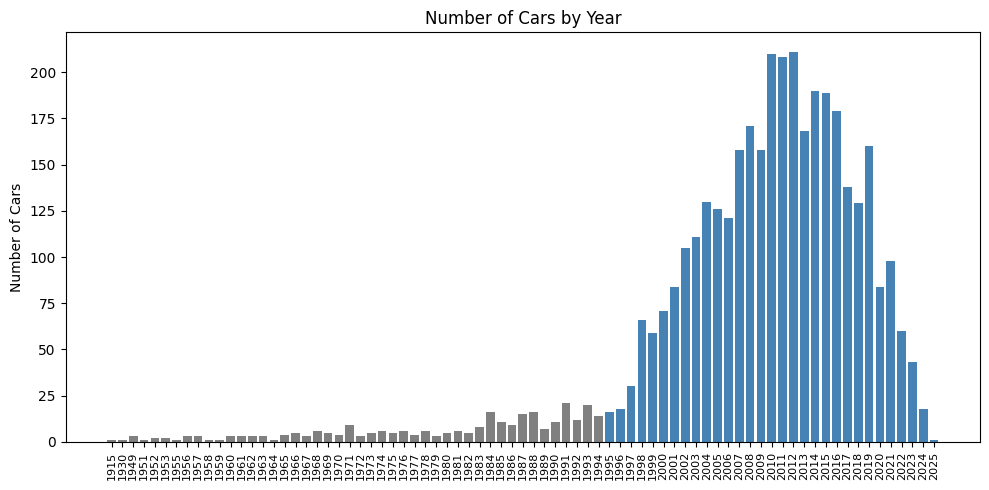

In [ ]:
year_count = df['year'].value_counts()
year_count_df = pd.DataFrame(year_count).reset_index().sort_values(by='year')
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(x=year_count_df[year_count_df['year']<(2025-30)]['year'].astype('str'),height= year_count_df[year_count_df['year']<(2025-30)]['count'], color='grey')
plt.bar(x=year_count_df[year_count_df['year']>=(2025-30)]['year'].astype('str'),height= year_count_df[year_count_df['year']>=(2025-30)]['count'], color='steelblue')
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("Number of Cars")
plt.title("Number of Cars by Year")
plt.tight_layout()
plt.show()

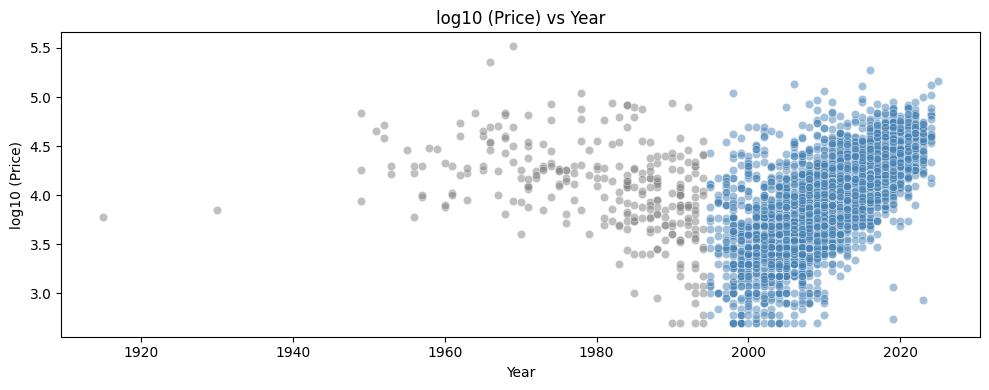

In [ ]:
plt.figure(figsize=(10, 4))
sns.scatterplot(data=df[df.year >= (2025-30)], x='year', y=df['price'], alpha=0.5, color='steelblue')
sns.scatterplot(data=df[df.year < (2025-30)], x='year', y=df['price'], alpha=0.5, color='grey')
plt.title("log10 (Price) vs Year")
plt.xlabel("Year")
plt.ylabel("log10 (Price)")
plt.tight_layout()
plt.show()

In [ ]:
all_samples_count = df.shape[0]
vintage_cars_count = df[df.year < (2025-30)].shape[0]
print(f'Number of samples of vintage cars: {vintage_cars_count}')
print(f'Percentage of samples of vintage cars: {vintage_cars_count / all_samples_count* 100:.2f}%')

Number of samples of vintage cars: 282
Percentage of samples of vintage cars: 7.44%


<b>Observation</b><br>
In Switzerland, the convention defines a vintage car as one first registered over 30 years ago. Interestingly, the sample data from the past 30 years shows an almost perfect normal distribution.

<b>Decision</b><br>
Although a significant portion of the samples (7.44%) are vintage cars, we chose to remove them from the dataset and train the model on "regular" cars only. As seen in the price scatterplot, vintage cars belong to a different market, with distinct pricing dynamics and a different customer base.

In [ ]:
# 1 - Remove vintage cars from the dataset
df = df[df.year >= 2025-30]

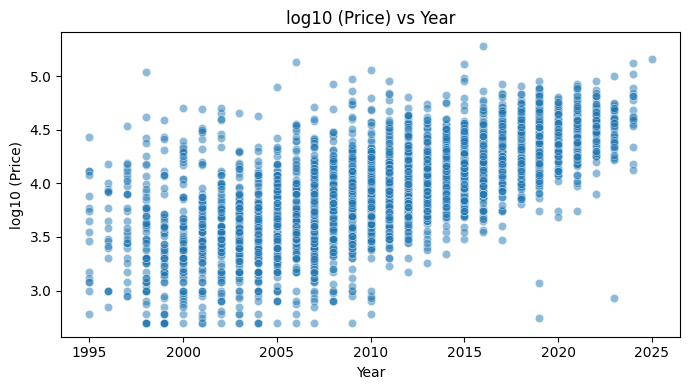

In [ ]:
plt.figure(figsize=(7, 4))
sns.scatterplot(data=df, x='year', y=df['price'], alpha=0.5)
plt.title("log10 (Price) vs Year")
plt.xlabel("Year")
plt.ylabel("log10 (Price)")
plt.tight_layout()
plt.show()

> **Assessing correlation with the target variable**

In [ ]:
corr = df['year'].corr(df['price'])
print(f"Correlation between year and price: {corr:.3f}")

Correlation between year and price: 0.677


<b>Conclusion</b><br>
We can now observe a clear trend: older cars tend to sell at lower prices, clearly displaying a moderately strong positive relationship.

The relationship is not fully explanatory, as additional factors such as brand, model, condition, and fuel type exert a significant influence on price.

### **Analysis of Date and Time Features**

#### **Published at feature**

In [ ]:
df.date_published = pd.to_datetime(df.date_published, dayfirst=True)
print('min date:',df.date_published.min())
print('max date:',df.date_published.max())

min date: 2025-05-30 00:00:00
max date: 2025-06-28 00:00:00


<b>Observation</b><br>
All listings were published within the same month. This means the current analysis and model training provide a snapshot of the car market as it was in June 2025. It is not a time series analysis, and it does not capture market trends over time. The model will predict vehicle prices as if they were sold in June 2025.

 To stay relevant, the entire process, from data collection to model training, must be repeated periodically. Injecting information from external sources can be time-consuming, so the study also aims to find a faster, more efficient training process by enhancing the data directly available on the website. The goal is to improve the model's ability to retrain and update over time without relying on manual input or external classification.

 <b>Decision</b><br>
 Information of this feature can be used to keep track of the different versions of the trained model, but it can't be used during the train phase and will be dropped

In [ ]:
# 1 - remove the date_published column from the dataset
df = df.drop(columns=['date_published'])

### **Analysis of Categorical Features**

#### **Car Model Feature**

> **Checking data type and printing a few samples**

In [ ]:
print(df.model.dtype)
print(df.model.head(5))
print(df.model.tail(5))

object
reference_number
8068126       Toyota Yaris 1.0
8067971             Autres JAC
8053937    Chevrolet Camaro SS
8036429              Fiat 500e
6567250      BMW X6 40d pack m
Name: model, dtype: object
reference_number
5797210                       VW Polo
6684847             Citroën C crosser
7994789           Suzuki Grand vitara
6462940             Audi A3 sportback
7905353    BMW M135 xDrive Steptronic
Name: model, dtype: object


<b>Observation</b><br>
We can observe a consistent pattern in the car titles: the brand name appears first, followed by the model. It is therefore reasonable to split these two elements into separate columns. Separating brand and model helps reduce noise in the data and allows us to standardize the model names, which in turn reduces the number of unique values and helps the model better capture variability.

<b>Decision</b></br>
The list of car brands can be retrieved dynamically from the website, and it tends to remain stable over time since it follows a fixed classification that has been in place on the platform for many years.

In [ ]:
# 1 - retreive brand names from the website
def get_car_brands():
  base_url = "https://www.petitesannonces.ch/"
  headers = {"User-Agent": "Mozilla/5.0"}

  url = base_url + 'r/1403'
  response = requests.get(url, headers=headers)
  soup = BeautifulSoup(response.text, "lxml")
  sous_rubrique_list = soup.find('ul', class_='r')
  car_brands = [a.text.strip() for a in sous_rubrique_list.find_all('a')]

  return car_brands

car_brands = get_car_brands()

In [ ]:
# 2 - create two more columns: brand and model_short
brand_list = [b.upper() for b in car_brands]
def split_brand_model(full_model):
    full_model_upper = full_model.upper()
    for brand in brand_list:
        if full_model_upper.startswith(brand):
            return brand, full_model_upper[len(brand):].strip()
    return "NO_BRAND", full_model_upper.strip()
df[['brand', 'model_long']] = df['model'].apply(lambda x: pd.Series(split_brand_model(x)))

# 3 - remove the model column
df.drop(columns=['model'], inplace=True)

> **Inspect the contents and distribution of the two newly created features.**

#### **Brand Feature**

In [ ]:
print(df.sort_values(by='brand').brand.unique())
print(len(df.brand.unique()))

['ALFA ROMEO' 'ASTON MARTIN' 'AUDI' 'AUTRES' 'BENTLEY' 'BMW' 'CADILLAC'
 'CHEVROLET' 'CHRYSLER' 'CITROËN' 'DACIA' 'DAEWOO' 'DAIHATSU' 'DODGE'
 'FERRARI' 'FIAT' 'FORD' 'HONDA' 'HYUNDAI' 'INFINITI' 'JAGUAR' 'JEEP'
 'KIA' 'LAMBORGHINI' 'LANCIA' 'LAND ROVER' 'LEXUS' 'LOTUS' 'MASERATI'
 'MAZDA' 'MERCEDES-BENZ' 'MG' 'MINI' 'MITSUBISHI' 'NISSAN' 'OPEL'
 'PEUGEOT' 'PONTIAC' 'PORSCHE' 'RELIANT' 'RENAULT' 'ROVER' 'SAAB' 'SEAT'
 'SKODA' 'SMART' 'SSANG YONG' 'SUBARU' 'SUZUKI' 'TESLA' 'TOYOTA' 'VOLVO'
 'VW']
53


> **Analysis of Brand distribution by features count**

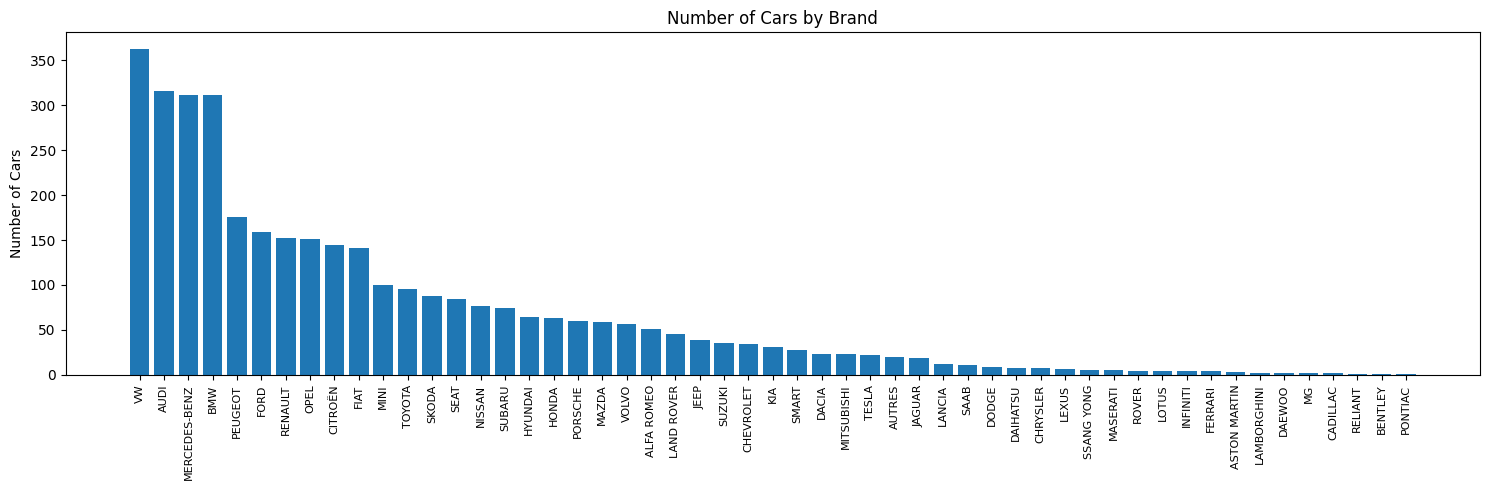

In [ ]:
brand_count = df['brand'].value_counts()
fig, ax = plt.subplots(figsize=(15,5))
plt.bar(x=brand_count.index, height=brand_count)
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("Number of Cars")
plt.title("Number of Cars by Brand")
plt.tight_layout()
plt.show()

**Observation**<br>
Some brands are highly popular, while others appear only in very small numbers, which is not unexpected.

**Decision**<br>
Group the less represented brands into a single "niche brands" category and conduct a deeper analysis of their behavior.

In [ ]:
# 1 - define a list of niche market brands
brand_counts = df['brand'].value_counts()
total_cars = len(df)
threshold = total_cars * 0.01

niche_market_brands = brand_counts[brand_counts < threshold].index
counts = brand_counts[brand_counts < threshold]

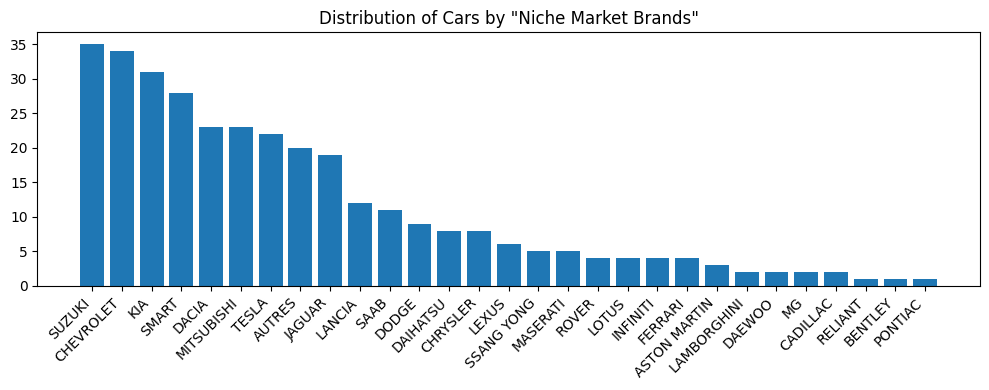

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(counts.index, counts.values)
plt.title('Distribution of Cars by "Niche Market Brands"')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


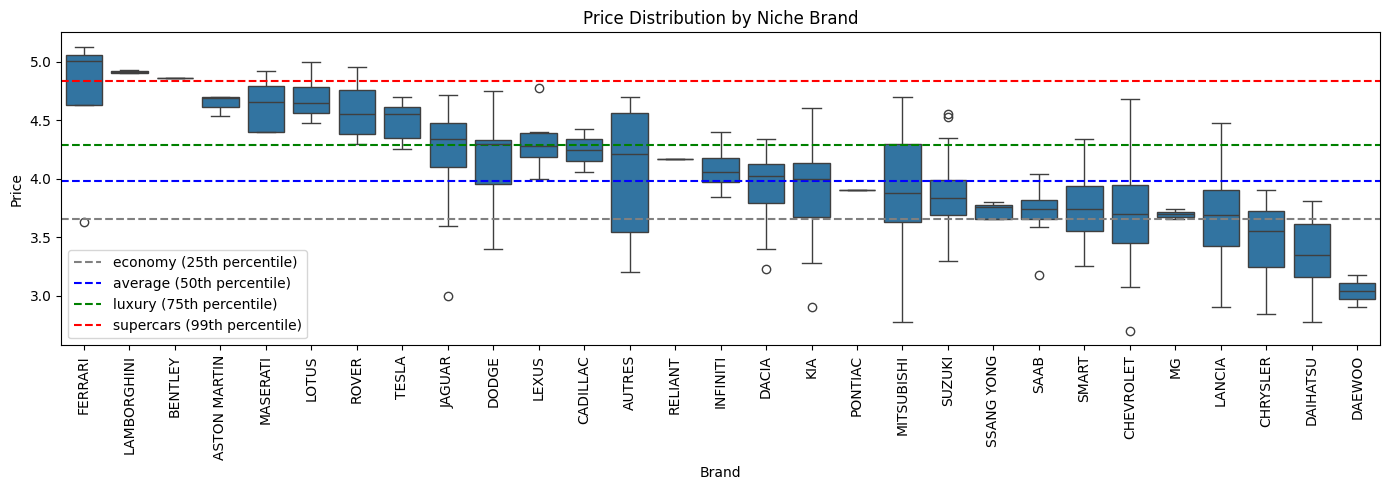

In [ ]:
df_niche = df[df['brand'].isin(niche_market_brands)].copy()
sorted_brands = df_niche.groupby('brand')['price'].median().sort_values(ascending=False).index

entry_level_market = df['price'].quantile(0.25)
average_market = df['price'].quantile(0.50)
luxury_market = df['price'].quantile(0.75)
supercar_market = df['price'].quantile(0.99)

plt.figure(figsize=(14, 5))
sns.boxplot(data=df_niche, x='brand', y='price', order=sorted_brands)
plt.axhline(entry_level_market, color='grey', linestyle='--', label='economy (25th percentile)')
plt.axhline(average_market, color='blue', linestyle='--', label='average (50th percentile)')
plt.axhline(luxury_market, color='green', linestyle='--', label='luxury (75th percentile)')
plt.axhline(supercar_market, color='red', linestyle='--', label='supercars (99th percentile)')

plt.title('Price Distribution by Niche Brand')
plt.xticks(rotation=90)
plt.ylabel('Price')
plt.xlabel('Brand')
plt.legend()
plt.tight_layout()
plt.show()

<b>Obsevation</b><br>
Some of the brand cars where represented by too few samples. We considered a threshold of 1% of samples as the lower limit, and defined all brands represented by less features as "niche brands". We also defined arbitrarly some car market segments, based on the target variable distribution. As this classification is based on the target variable, it won't be used to classify or regroup the samples. It's just an analysis that highlight the fact that simply regrouping niche brands in one category could lead to poor performance, due to the presence of supercars and luxury brand outliers.

<b>Decision</b><br>
Brands that are insufficienly represented will be grouped in a "niche brand" category, to ensure greater model stability and generalization despite the presence of outliers. Further EDA could help separating samples with outliers, by identifying them by a parameter other than the target variable.

As at this stage of the analysis it is impossible to define if the model could take advantage of the diversity, we create a new feature that groups the niche brands together, and we will fine-tune the strategy analysing the results of a simple linear regression trained on both versions, as a baseline.

In [ ]:
# 2 - Regroup brands whose number of samples is less than threshold (1%)
valid_brands = brand_counts[brand_counts >= threshold].index
df['make'] = df['brand'].apply(lambda x : 'NICHE_MARKET_BRAND'if x in niche_market_brands else x)

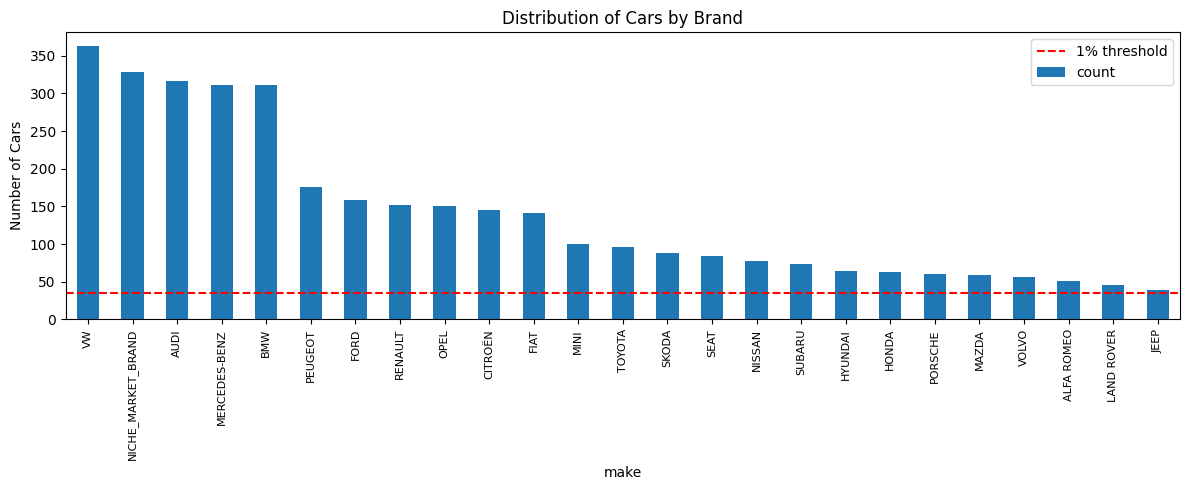

In [ ]:
make_counts = df['make'].value_counts()
plt.figure(figsize=(12, 5))
make_counts.plot(kind='bar')

plt.axhline(y=threshold, color='red', linestyle='--', label='1% threshold')
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("Number of Cars")
plt.title("Distribution of Cars by Brand")
plt.legend()
plt.tight_layout()
plt.show()

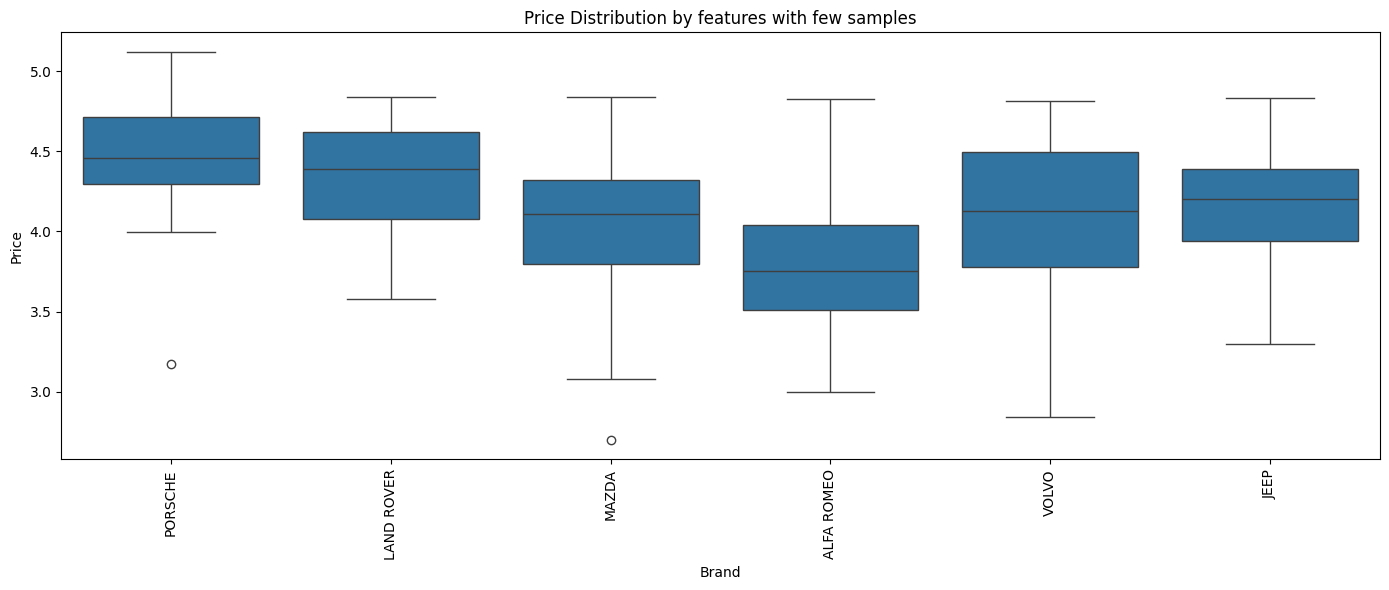

In [ ]:
few_samples_brands = ['JEEP', 'LAND ROVER', 'ALFA ROMEO','VOLVO','MAZDA', 'PORSCHE']
plt.figure(figsize=(14, 6))
sns.boxplot(data=df[df.brand.isin(few_samples_brands)], x='brand', y='price')

plt.title('Price Distribution by features with few samples')
plt.xticks(rotation=90)
plt.ylabel('Price')
plt.xlabel('Brand')
plt.tight_layout()
plt.show()

<b>Conclusion</b><br>
Despite the fact that the one percent threshold is very low, and some of the brands are represented by very few samples, we will retain this configuration at the moment. The 1% threshold grouped alredy a lot of samples with very different characteristics, and this could already lead to a poor model performance. Further analysis should be conduct in order to improve this solution, that could lead to suboptimal results.

#### **Model_short feature**

> **Exploring a few samples and the feature's distribution**

In [ ]:
print(df.model_long.head(5))
print(f'Number of unique values before cleaning: {len(df.model_long.unique())}')
print(' ')

# 1 - clean the model_short feature by keeping only the first word
df['model_short'] = df['model_long'].str.split().str[0]
print(df.model_short.head(5))
print(f'Number of unique values after cleaning: {len(df.model_short.unique())}')

reference_number
8068126        YARIS 1.0
8067971              JAC
8053937        CAMARO SS
8036429             500E
6567250    X6 40D PACK M
Name: model_long, dtype: object
Number of unique values before cleaning: 2548
 
reference_number
8068126     YARIS
8067971       JAC
8053937    CAMARO
8036429      500E
6567250        X6
Name: model_short, dtype: object
Number of unique values after cleaning: 841


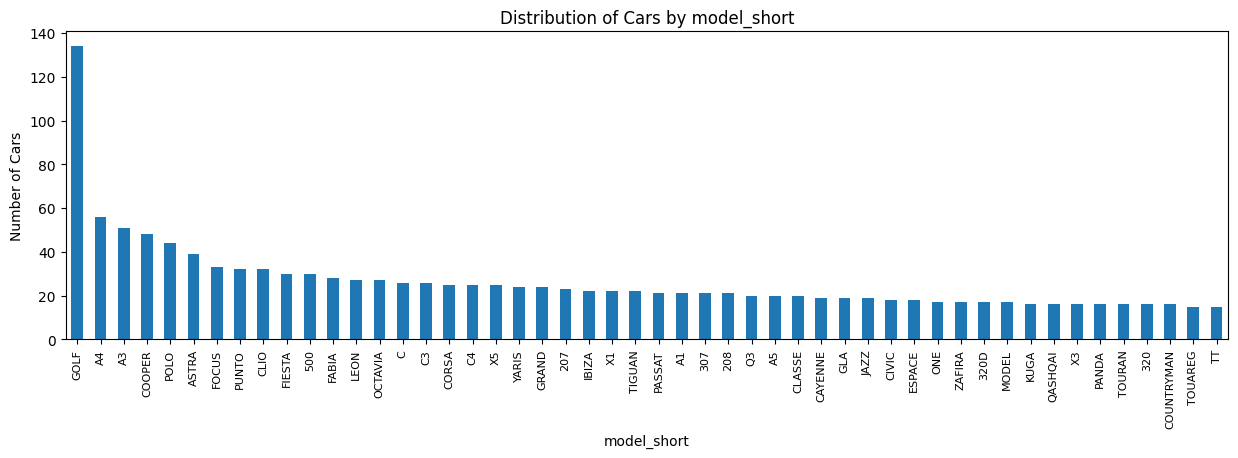

In [ ]:
model_counts = df['model_short'].value_counts()
fig, ax = plt.subplots(figsize=(15, 4))
model_counts.head(50).plot(kind='bar')
plt.title('Distribution of Cars by model_short')
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("Number of Cars")
plt.xlabel('model_short')
plt.show()

<b>Observation</b><br>
The feature contains more than just one information. Along with the model name, which in general come as the first word of the feature, other information like the engine displacement or different options. This information, not being well structured, lead to too many unique values, that would make the feature impossible to use for a model training.

We decided to drop all the extra information, keeping only the first word. Even if there is no guarantee that the first used word will be indeed the model name, a brief analysis of the first 40 samples seems to confirm that most of the time, this is the chosen pattern. Also, it appear evident that, even if the number of unique values dropped to around 800, only the most common 10 or 15 models contain a sufficient amount of sample per model.

<b>Decision</b><br>
This feature is unlikely to carry meaningful information during the model training, because of the low amount of samples per category. We decide to keep in the dataset anyway, including the two versions in the first baseline evaluation.

#### **Transmission Type feature**

Number of unique values in transmission: 3
Number of null values in transmission: 0
Distribution of transmission types: transmission
Manuelle        1877
Automatique     1464
Séquentielle     169
Name: count, dtype: int64
Distribution of fuel types: transmission
Manuelle        1877
Automatique     1464
Séquentielle     169
Name: count, dtype: int64


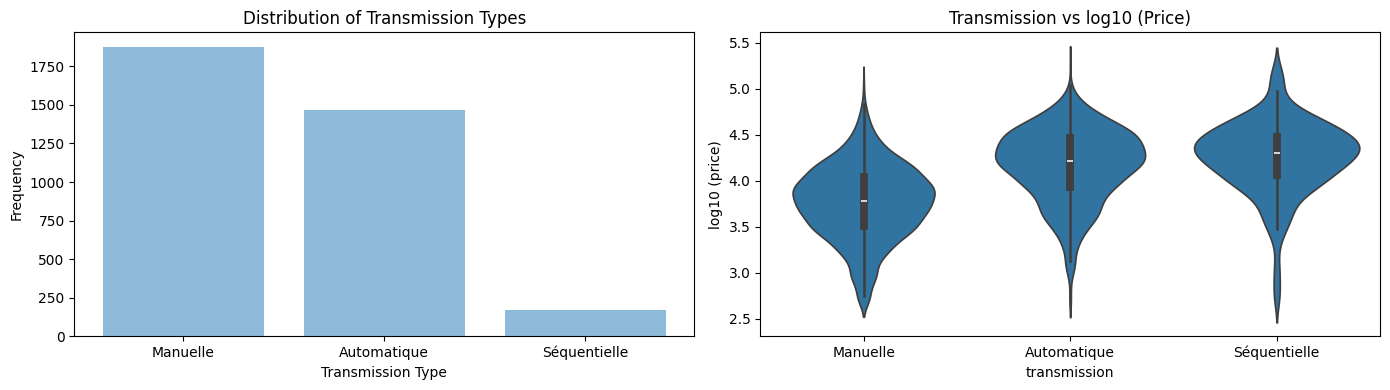

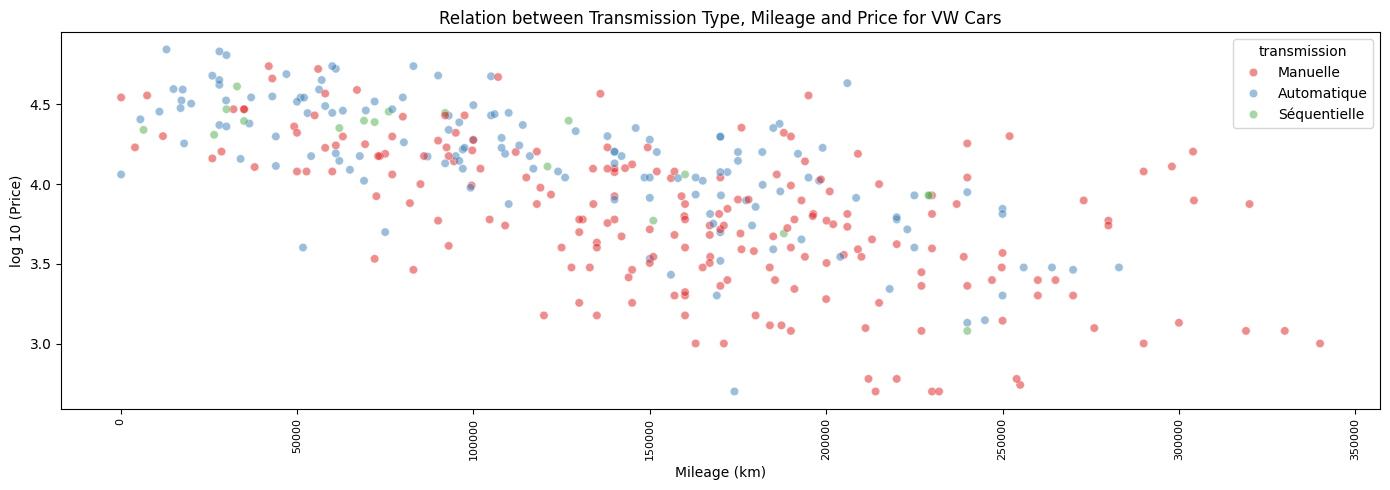

In [ ]:
print(f'Number of unique values in transmission: {len(df.transmission.unique())}')
print(f'Number of null values in transmission: {df.transmission.isnull().sum()}')
print(f'Distribution of transmission types: {df.transmission.value_counts()}')

counts = df['transmission'].value_counts()
print(f'Distribution of fuel types: {counts}')
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].bar(counts.index, counts.values, alpha=0.5)
axes[0].set_title('Distribution of Transmission Types')
axes[0].set_xlabel('Transmission Type')
axes[0].set_ylabel('Frequency')
sns.violinplot(ax=axes[1], data=df, x='transmission', y=df['price'])
axes[1].set_title('Transmission vs log10 (Price)')
axes[1].set_ylabel('log10 (price)')
axes[1].tick_params(axis='x')
plt.tight_layout()
plt.show()

brand = 'VW'
plt.figure(figsize=(14, 5))
sns.scatterplot(data=df[df.brand == brand].sort_values(by='price'), x='mileage_km', y=df['price'], alpha=0.5, hue='transmission', palette='Set1')
plt.title('Relation between Transmission Type, Mileage and Price for VW Cars')
plt.xticks(rotation=90, fontsize=8)
plt.xlabel("Mileage (km)")
plt.ylabel("log 10 (Price)")
plt.tight_layout()
plt.show()

**Conclusion**<br>
A clear trend emerges: manual transmissions are more common in lower-priced cars. No need for further data preparation, apart from integer encoding

#### **Fuel Type feature**

Number of unique values in fuel: 5
Number of null values in fuel: 0
Distribution of fuel types: fuel
Essence                2459
Diesel                  964
Electrique               73
Gaz naturel/Essence      13
Gaz naturel               1
Name: count, dtype: int64


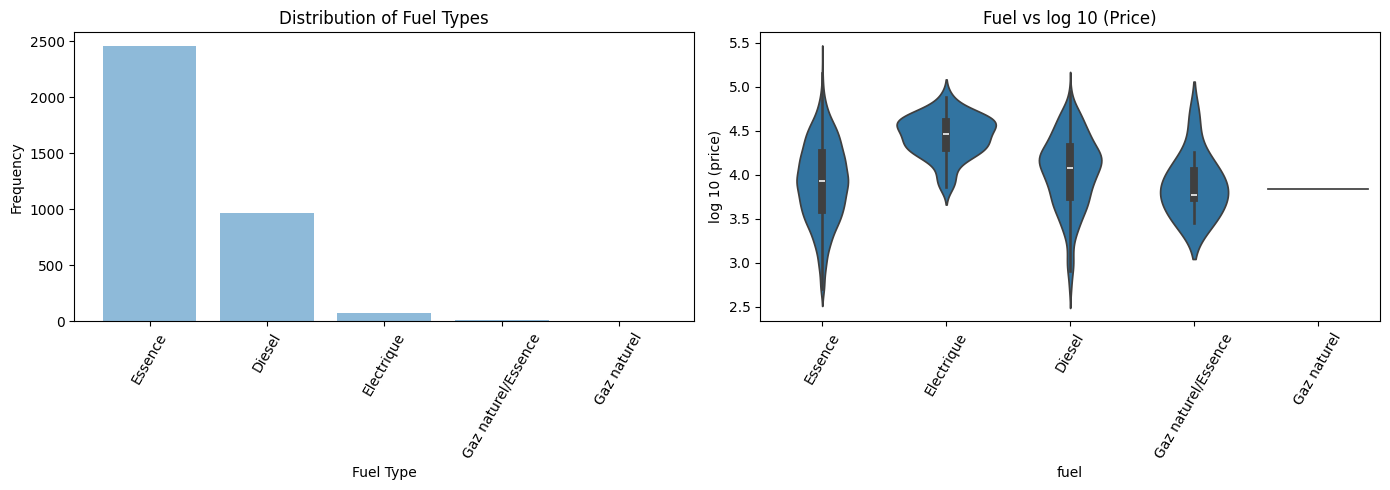

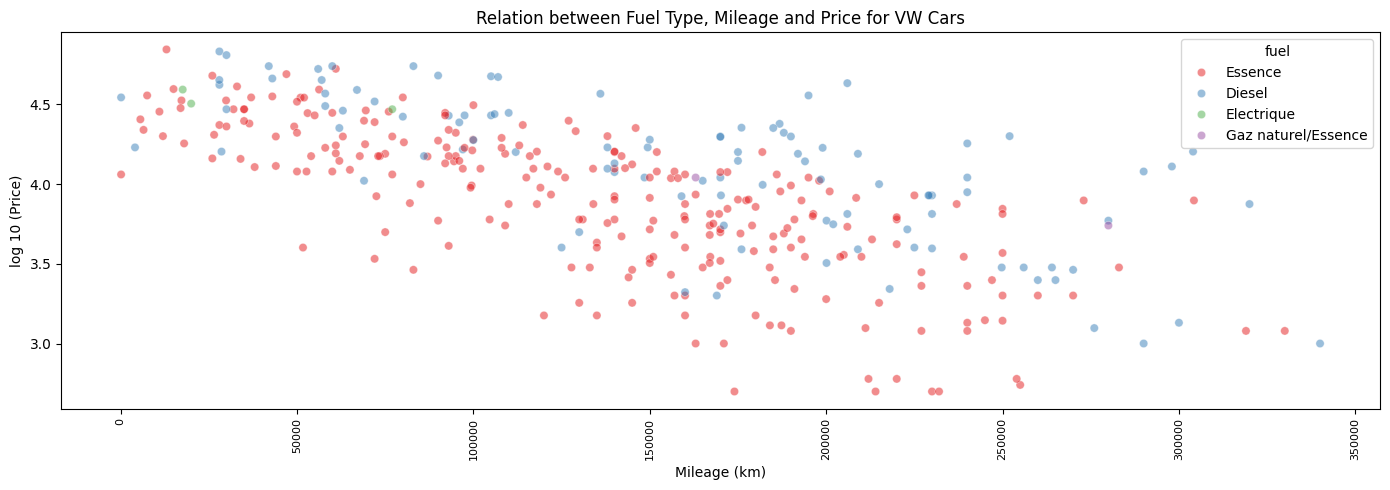

In [ ]:
print(f'Number of unique values in fuel: {len(df.fuel.unique())}')
print(f'Number of null values in fuel: {df.fuel.isnull().sum()}')

counts = df['fuel'].value_counts()
print(f'Distribution of fuel types: {counts}')
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(counts.index, counts.values, alpha=0.5)
axes[0].set_title('Distribution of Fuel Types')
axes[0].set_xlabel('Fuel Type')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=60)
sns.violinplot(ax=axes[1], data=df, x='fuel', y=df['price'])
axes[1].set_title('Fuel vs log 10 (Price)')
axes[1].set_ylabel('log 10 (price)')
axes[1].tick_params(axis='x', rotation=60)
plt.tight_layout()
plt.show()

brand = 'VW'
plt.figure(figsize=(14, 5))
sns.scatterplot(data=df[df.brand == brand].sort_values(by='price'), x='mileage_km', y=df['price'], alpha=0.5, hue='fuel', palette='Set1')
plt.title('Relation between Fuel Type, Mileage and Price for VW Cars')
plt.xticks(rotation=90, fontsize=8)
plt.xlabel("Mileage (km)")
plt.ylabel("log 10 (Price)")
plt.tight_layout()
plt.show()

**Conclusion**<br>
It is noteworthy that petrol cars are consistently less expensive than diesel cars across all mileage levels. Electric cars currently occupy a niche market segment, commanding high prices at the time of this analysis; however, this trend may evolve in the coming years.Different gas samples with similar labels can be combined

In [ ]:
# 1 - replace 'Gaz naturel' with 'Gaz naturel/Essence' in the fuel column
df['fuel'] = df['fuel'].replace({
    'Gaz naturel': 'Gaz naturel/Essence'
})

#### **External Color feature**

> **Printing unique values**

In [ ]:
df.external_color.unique()

array(['Blanc', 'Blanc (métallisé)', 'Noir (métallisé)',
       'Gris (métallisé)', 'Rouge (métallisé)', 'Anthracite (métallisé)',
       'Vert (métallisé)', 'Vert foncé (métallisé)',
       'Bleu foncé (métallisé)', 'Vert foncé', 'Noir', 'Gris', 'Jaune',
       'Bleu (métallisé)', 'Bleu foncé', 'Argent (métallisé)',
       'Beige (métallisé)', 'Rouge', 'Bleu', 'Bleu clair (métallisé)',
       'Anthracite', 'Orange (métallisé)', 'Bordeaux (métallisé)',
       'Orange', 'Jaune (métallisé)', 'Vert clair (métallisé)',
       'Bleu clair', 'Vert clair', 'Vert', 'Or (métallisé)', 'Bordeaux',
       'Beige'], dtype=object)

**Observation**<br>
The variable contains three distinct pieces of information: the color, the shade and the metallic finish. These can be separated into different features to better analyze their individual influence on the target variable.

external color unique values are: ['Blanc' 'Noir' 'Gris' 'Rouge' 'Anthracite' 'Vert' 'Bleu' 'Jaune' 'Argent'
 'Beige' 'Orange' 'Bordeaux' 'Or']


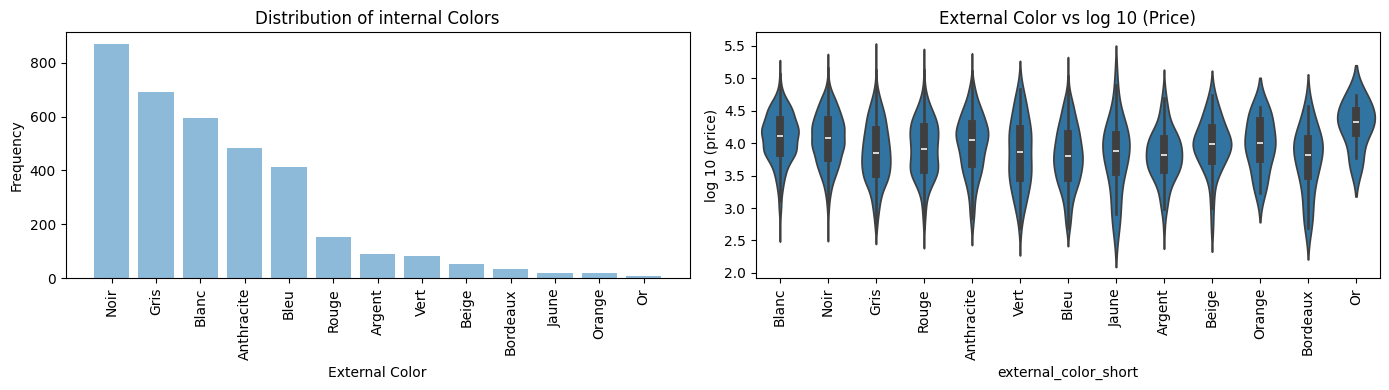

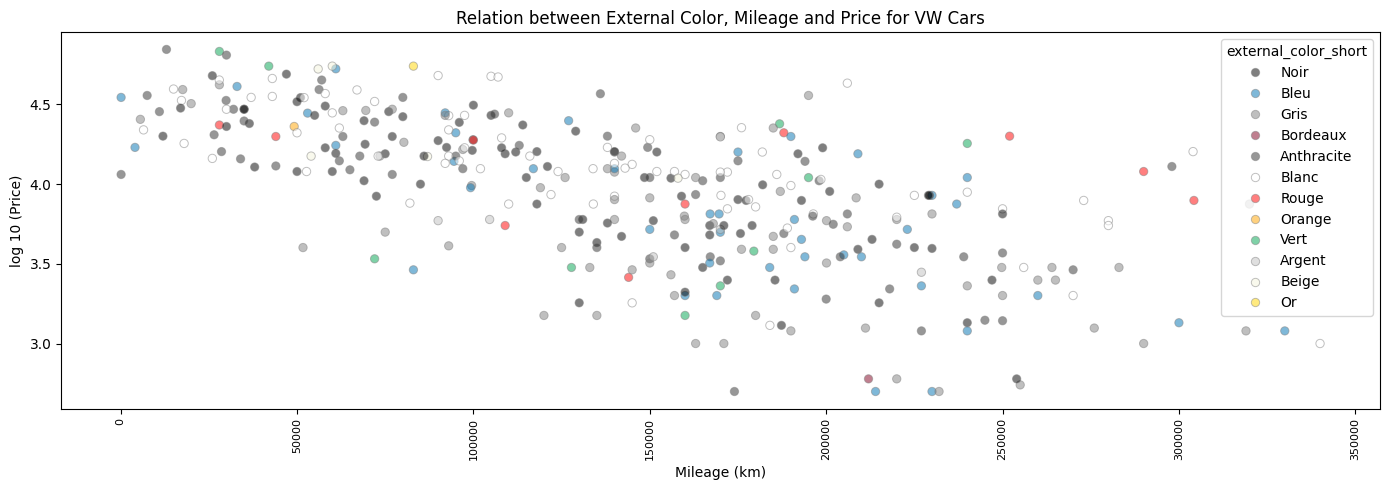

In [ ]:
# 1 - create a external color short feature
df['external_color_short'] = df.external_color.apply(lambda x: x.split(' ')[0])
print(f'external color unique values are: {df.external_color_short.unique()}')
counts = df['external_color_short'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].bar(counts.index, counts.values, alpha=0.5)
axes[0].set_title('Distribution of internal Colors')
axes[0].set_xlabel('External Color')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=90)

sns.violinplot(ax=axes[1], data=df, x='external_color_short', y=df['price'])
axes[1].set_title('External Color vs log 10 (Price)')
axes[1].set_ylabel('log 10 (price)')
axes[1].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

custom_palette = {
    'Blanc': "#FFFFFF8D",
    'Noir': '#000000',
    'Gris': '#808080',
    'Rouge': '#FF0000',
    'Anthracite': '#303030',
    'Vert': '#00A550',
    'Bleu': '#0072B2',
    'Jaune': '#FFD700',
    'Argent': '#C0C0C0',
    'Beige': '#F5F5DC',
    'Orange': '#FFA500',
    'Bordeaux': '#800020',
    'Or': '#FFD700'
}

brand = 'VW'
plt.figure(figsize=(14, 5))
sns.scatterplot(data=df[df.brand == brand].sort_values(by='price'), x='mileage_km', y=df['price'], alpha=0.5, hue='external_color_short', palette=custom_palette, edgecolors='grey', linewidths=0.7)
plt.title('Relation between External Color, Mileage and Price for VW Cars')
plt.xticks(rotation=90, fontsize=8)
plt.xlabel("Mileage (km)")
plt.ylabel("log 10 (Price)")
plt.tight_layout()
plt.show()

**Observation**<br>
No strong relationship is observed. The potential usefulness of this feature in the final model should be further examined through correlation analysis. Rare colors may be consolidated into an "Other" category.

In [ ]:
# 2 - create an external_color_grouped feature
df['external_color_grouped'] = df['external_color_short'].apply(lambda x : x if x in ['Noir', 'Gris', 'Blanc', 'Anthracite', 'Bleu'] else 'Autres')

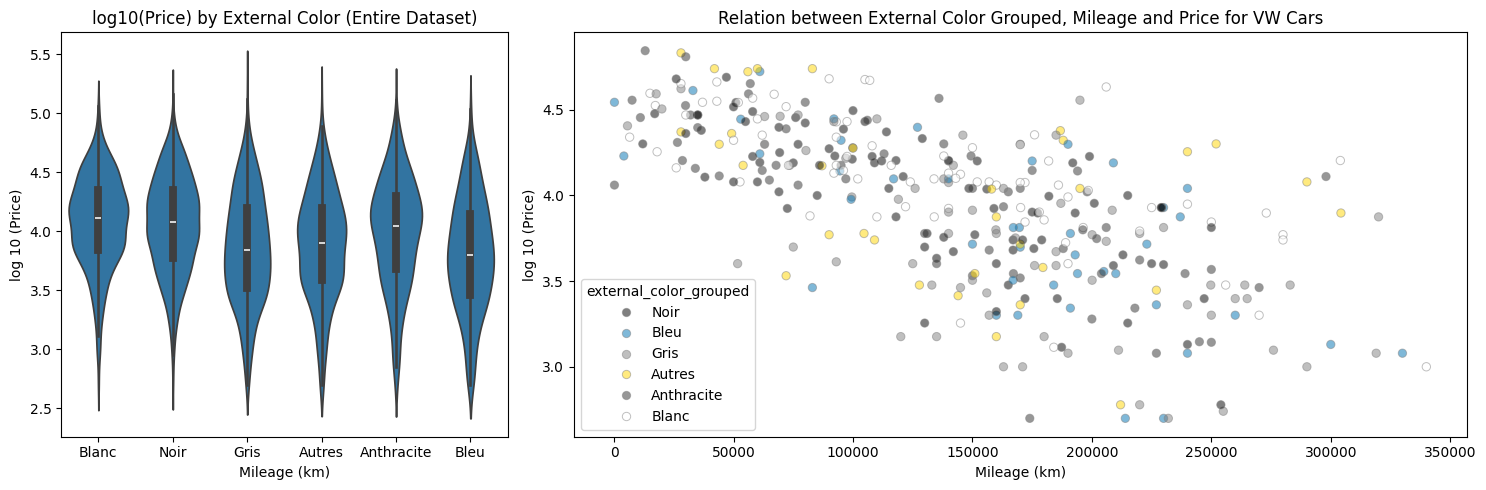

In [ ]:
custom_palette = {
    'Blanc': "#FFFFFF8D",
    'Noir': '#000000',
    'Gris': '#808080',
    'Anthracite': '#303030',
    'Bleu': '#0072B2',
    'Autres': '#FFD700'
}

fig, axes = plt.subplots(1,2,figsize=(15, 5),gridspec_kw={'width_ratios': [5, 10]})
sns.violinplot(ax= axes[0], data=df, x='external_color_grouped', y=df['price'])
axes[0].set_title('log10(Price) by External Color (Entire Dataset)')
axes[0].set_xlabel("Mileage (km)")
axes[0].set_ylabel("log 10 (Price)")

brand = 'VW'
sns.scatterplot(ax= axes[1], data=df[df.brand == brand].sort_values(by='price'), x='mileage_km', y=df['price'], alpha=0.5, hue='external_color_grouped', palette=custom_palette, edgecolors='grey', linewidths=0.7)
axes[1].set_title('Relation between External Color Grouped, Mileage and Price for VW Cars')
axes[1].set_xlabel("Mileage (km)")
axes[1].set_ylabel("log 10 (Price)")
plt.tight_layout()
plt.show()

In [ ]:
# 3 - create external color shade feature
df['external_color_shade'] =  np.where(
  df['external_color'].str.contains('foncé|clair', na=False),
  df['external_color'].str.split(' ').str[1],
  'normal'
)

In [ ]:
df.external_color_shade.unique()

array(['normal', 'foncé', 'clair'], dtype=object)

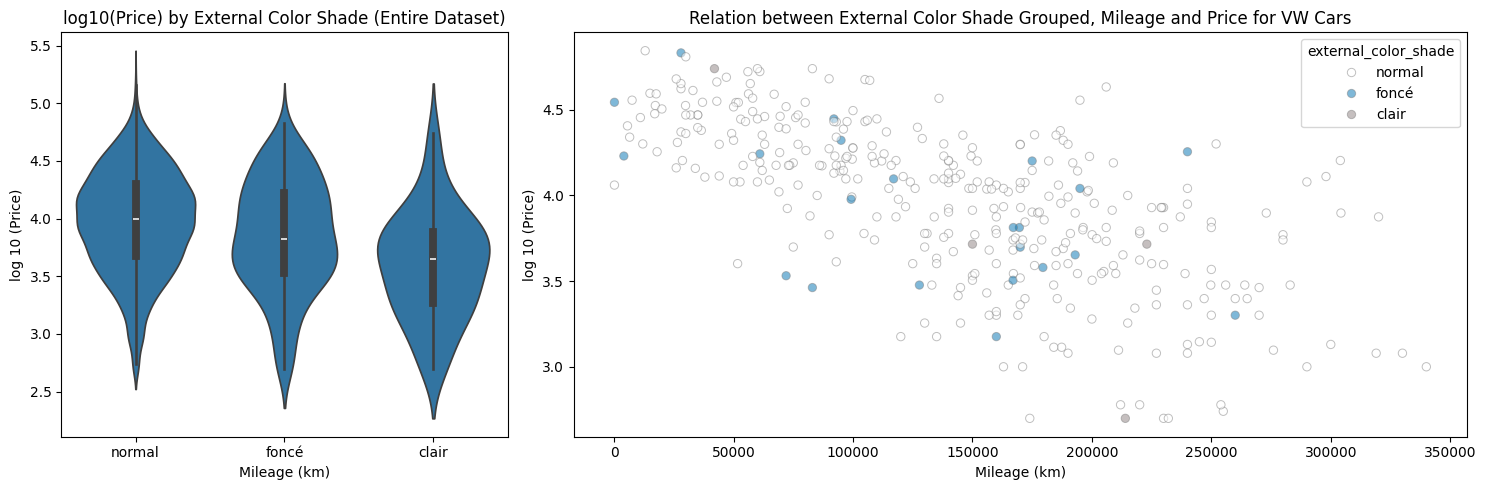

In [ ]:
custom_palette = {
    'clair': '#8D808080',
    'normal': "#FFFFFF",
    'foncé': '#0072B2'
}

fig, axes = plt.subplots(1,2,figsize=(15, 5),gridspec_kw={'width_ratios': [5, 10]})
sns.violinplot(ax= axes[0], data=df, x='external_color_shade', y=df['price'])
axes[0].set_title('log10(Price) by External Color Shade (Entire Dataset)')
axes[0].set_xlabel("Mileage (km)")
axes[0].set_ylabel("log 10 (Price)")

brand = 'VW'
sns.scatterplot(ax= axes[1], data=df[df.brand == brand].sort_values(by='price'), x='mileage_km', y=df['price'], alpha=0.5, hue='external_color_shade', palette=custom_palette, edgecolors='grey', linewidths=0.7)
axes[1].set_title('Relation between External Color Shade Grouped, Mileage and Price for VW Cars')
axes[1].set_xlabel("Mileage (km)")
axes[1].set_ylabel("log 10 (Price)")
plt.tight_layout()
plt.show()

In [ ]:
# 4 - create external color metallic finish feature
df['external_color_metallic'] =  np.where(
  df['external_color'].str.contains(r'\(métallisé\)', na=False),
  df['external_color'].str.split(' ').str[-1],
  'normal'
)

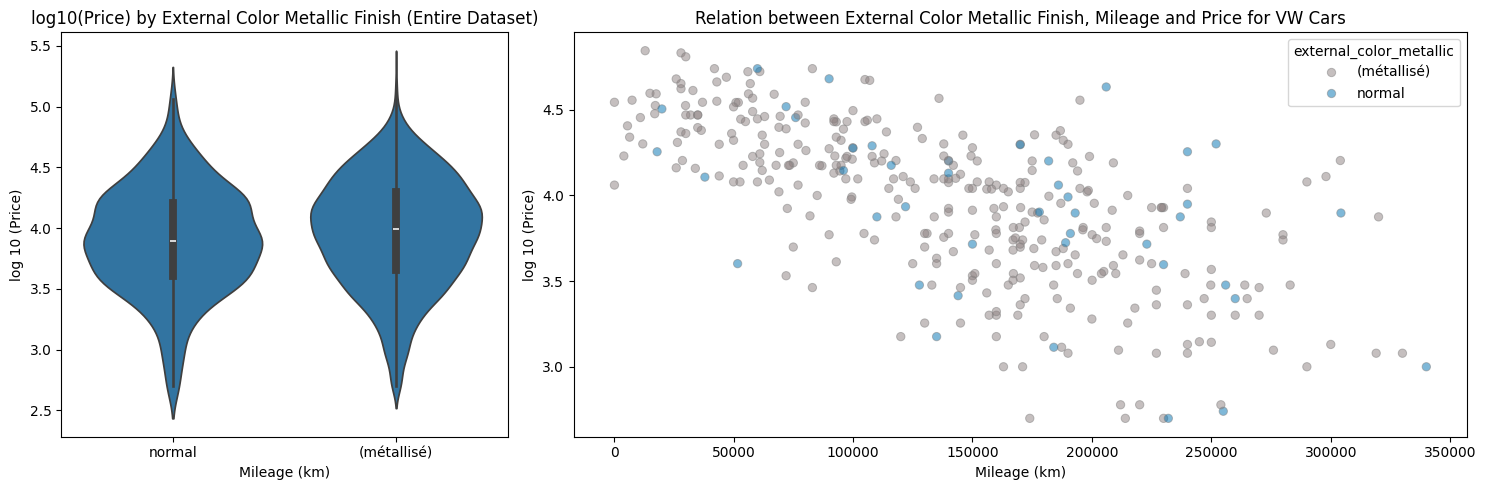

In [ ]:
custom_palette = {
    '(métallisé)': '#8D808080',
    'normal': '#0072B2'
}

fig, axes = plt.subplots(1,2,figsize=(15, 5),gridspec_kw={'width_ratios': [5, 10]})
sns.violinplot(ax= axes[0], data=df, x='external_color_metallic', y=df['price'])
axes[0].set_title('log10(Price) by External Color Metallic Finish (Entire Dataset)')
axes[0].set_xlabel("Mileage (km)")
axes[0].set_ylabel("log 10 (Price)")

brand = 'VW'
sns.scatterplot(ax= axes[1], data=df[df.brand == brand].sort_values(by='price'), x='mileage_km', y=df['price'], alpha=0.5, hue='external_color_metallic', palette=custom_palette, edgecolors='grey', linewidths=0.7)
axes[1].set_title('Relation between External Color Metallic Finish, Mileage and Price for VW Cars')
axes[1].set_xlabel("Mileage (km)")
axes[1].set_ylabel("log 10 (Price)")
plt.tight_layout()
plt.show()

#### **Internal Color feature**

> **Print unique values**

In [ ]:
print(f'internal color unique values are: {df.internal_color.unique()}')

internal color unique values are: ['Gris' 'Gris (cuir)' 'Noir (cuir)' 'Anthracite' 'Anthracite (cuir)'
 'Beige (cuir)' 'Rouge' 'Noir' 'Bleu' 'Bordeaux (cuir)' 'Blanc (cuir)'
 'Beige' 'Rouge (cuir)' 'Bleu clair' 'Bleu (cuir)' 'Blanc' 'Argent (cuir)'
 'Orange (cuir)' 'Bleu foncé (cuir)' 'Argent' 'Bleu foncé' 'Orange'
 'Bordeaux' 'Vert' 'Vert clair' 'Bleu clair (cuir)' 'Jaune' 'Jaune (cuir)'
 'Or' 'Vert (cuir)' 'Vert foncé']


**Observation**<br>
The internal color can also be splitted into different features as it includes the shade and material information

In [ ]:
# 1 - split into internal_color_short feature
df['internal_color_short'] = df.internal_color.apply(lambda x: x.split(' ')[0])

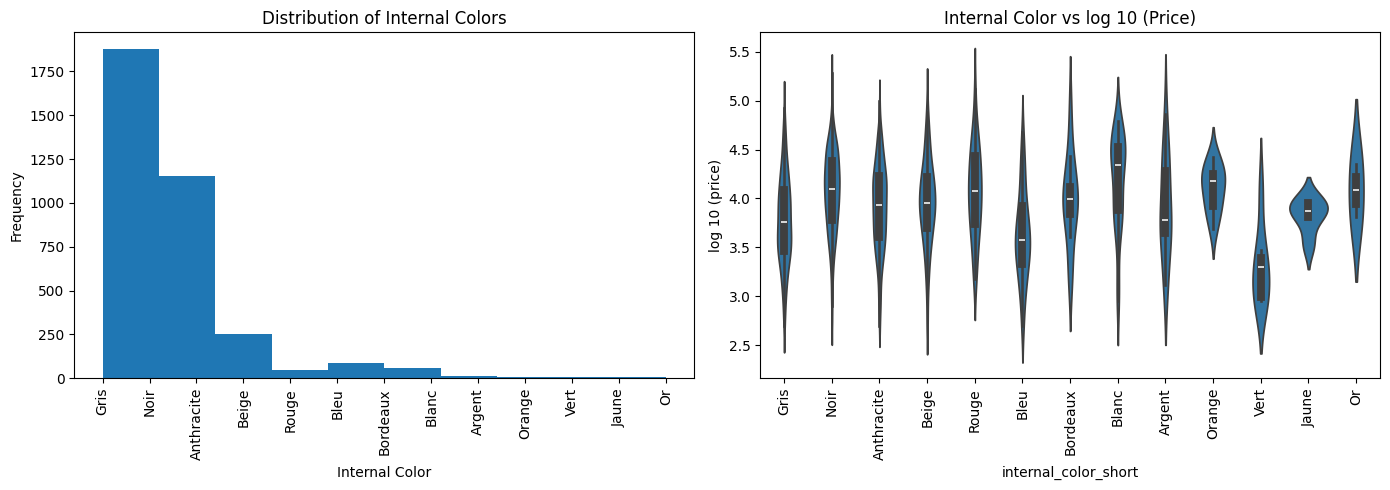

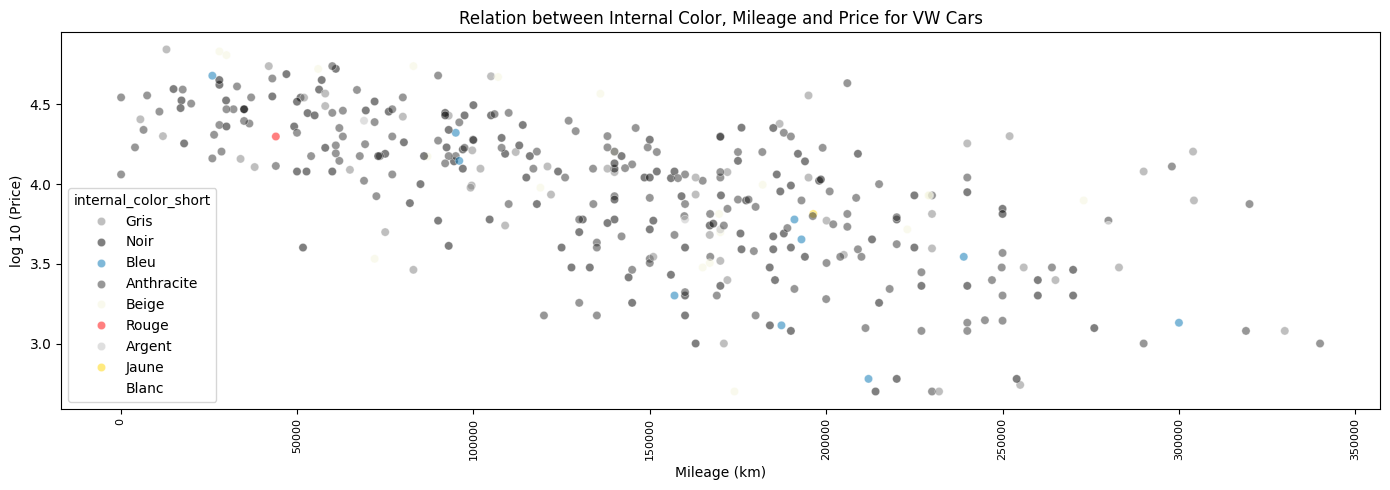

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(df['internal_color_short'])
axes[0].set_title('Distribution of Internal Colors')
axes[0].set_xlabel('Internal Color')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=90)
sns.violinplot(ax=axes[1], data=df, x='internal_color_short', y=df['price'])
axes[1].set_title('Internal Color vs log 10 (Price)')
axes[1].set_ylabel('log 10 (price)')
axes[1].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

custom_palette = {
    'Blanc': "#FFFFFFCA",
    'Noir': '#000000',
    'Gris': '#808080',
    'Rouge': '#FF0000',
    'Anthracite': '#303030',
    'Vert': '#00A550',
    'Bleu': '#0072B2',
    'Jaune': '#FFD700',
    'Argent': '#C0C0C0',
    'Beige': '#F5F5DC',
    'Orange': '#FFA500',
    'Bordeaux': '#800020',
    'Or': '#FFD700'
}
brand = 'VW'
plt.figure(figsize=(14, 5))
sns.scatterplot(data=df[df.brand == brand].sort_values(by='price'), x='mileage_km', y=df['price'], alpha=0.5, hue='internal_color_short', palette=custom_palette)
plt.title('Relation between Internal Color, Mileage and Price for VW Cars')
plt.xticks(rotation=90, fontsize=8)
plt.xlabel("Mileage (km)")
plt.ylabel("log 10 (Price)")
plt.tight_layout()
plt.show()

**Observation**<br>
Similarly to the previous external color feature, no clear trend is visible, and less represented colors can be group together.

In [ ]:
# 2 - create an internal_color_grouped feature
df['internal_color_grouped'] = df['internal_color_short'].apply(lambda x : x if x in ['Noir', 'Gris',  'Anthracite'] else 'Autres')

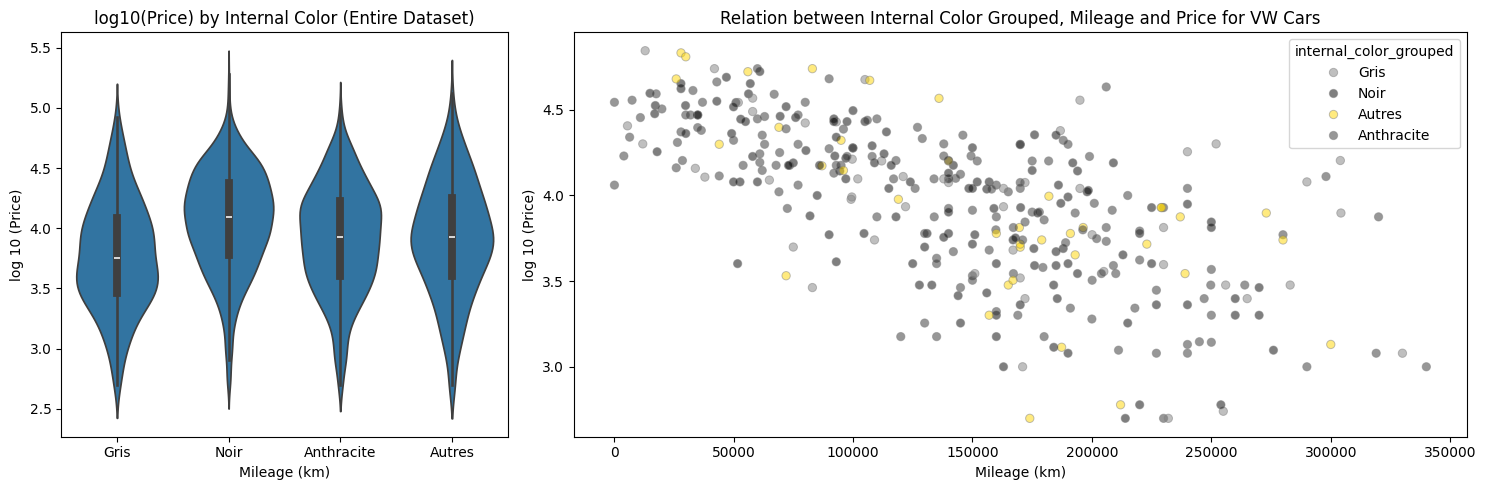

In [ ]:
custom_palette = {
    'Noir': '#000000',
    'Gris': '#808080',
    'Anthracite': '#303030',
    'Autres': '#FFD700'
}


fig, axes = plt.subplots(1,2,figsize=(15, 5),gridspec_kw={'width_ratios': [5, 10]})
sns.violinplot(ax= axes[0], data=df, x='internal_color_grouped', y=df['price'])
axes[0].set_title('log10(Price) by Internal Color (Entire Dataset)')
axes[0].set_xlabel("Mileage (km)")
axes[0].set_ylabel("log 10 (Price)")

brand = 'VW'
sns.scatterplot(ax= axes[1], data=df[df.brand == brand].sort_values(by='price'), x='mileage_km', y=df['price'], alpha=0.5, hue='internal_color_grouped', palette=custom_palette, edgecolors='grey', linewidths=0.7)
axes[1].set_title('Relation between Internal Color Grouped, Mileage and Price for VW Cars')
axes[1].set_xlabel("Mileage (km)")
axes[1].set_ylabel("log 10 (Price)")
plt.tight_layout()
plt.show()

In [ ]:
# 3 - create internal color shade feature
df['internal_color_shade'] =  np.where(
  df['internal_color'].str.contains('foncé|clair', na=False),
  df['internal_color'].str.split(' ').str[1],
  'normal'
)

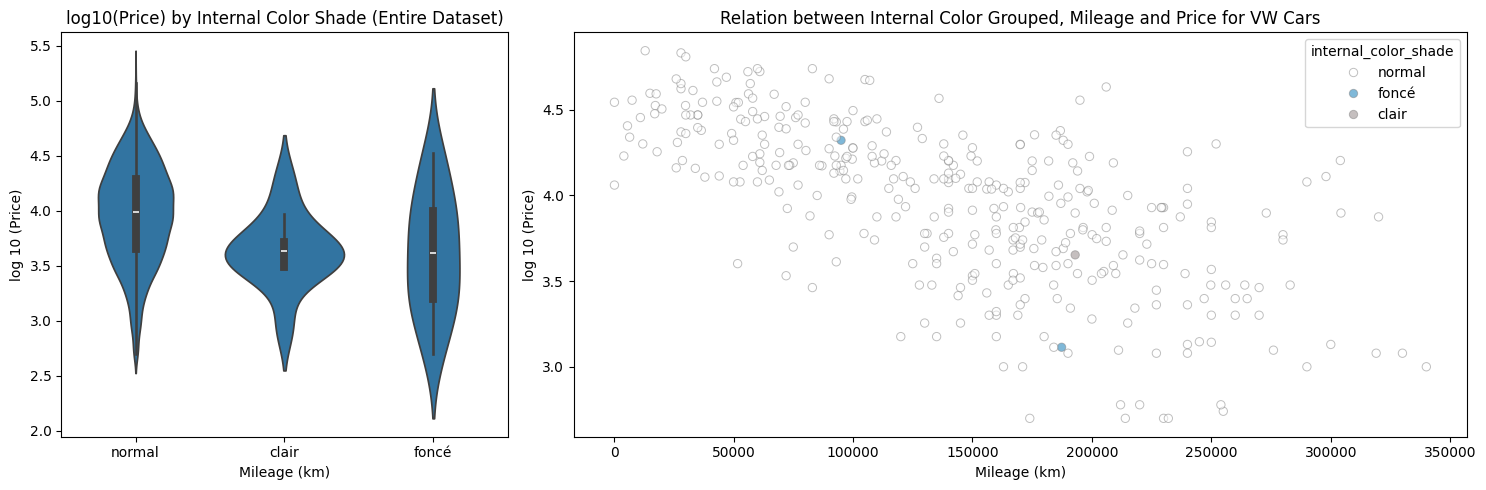

In [ ]:
custom_palette = {
    'clair': '#8D808080',
    'normal': "#FFFFFF",
    'foncé': '#0072B2'
}

fig, axes = plt.subplots(1,2,figsize=(15, 5),gridspec_kw={'width_ratios': [5, 10]})
sns.violinplot(ax= axes[0], data=df, x='internal_color_shade', y=df['price'])
axes[0].set_title('log10(Price) by Internal Color Shade (Entire Dataset)')
axes[0].set_xlabel("Mileage (km)")
axes[0].set_ylabel("log 10 (Price)")

brand = 'VW'
sns.scatterplot(ax= axes[1], data=df[df.brand == brand].sort_values(by='price'), x='mileage_km', y=df['price'], alpha=0.5, hue='internal_color_shade', palette=custom_palette, edgecolors='grey', linewidths=0.7)
axes[1].set_title('Relation between Internal Color Grouped, Mileage and Price for VW Cars')
axes[1].set_xlabel("Mileage (km)")
axes[1].set_ylabel("log 10 (Price)")
plt.tight_layout()
plt.show()

In [ ]:
# 4 - create internal color leather material feature
df['internal_color_leather'] =  np.where(
  df['internal_color'].str.contains('cuir', na=False),
  df['internal_color'].str.split(' ').str[-1],
  'normal'
)

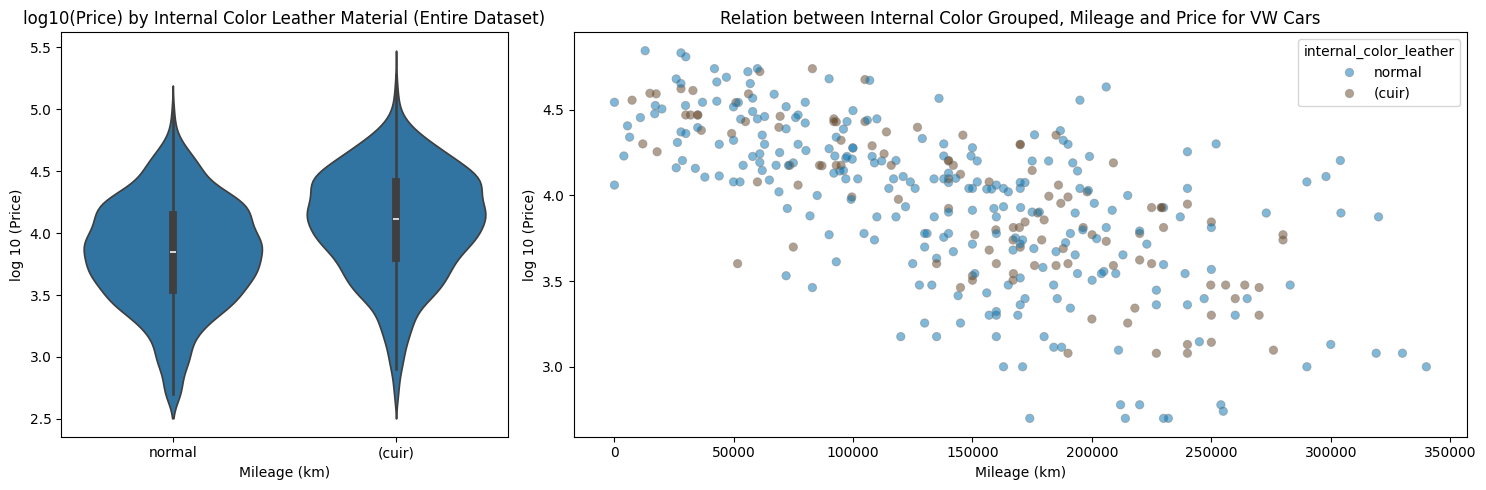

In [ ]:
custom_palette = {
    '(cuir)': '#654321',
    'normal': '#0072B2'
}

fig, axes = plt.subplots(1,2,figsize=(15, 5),gridspec_kw={'width_ratios': [5, 10]})
sns.violinplot(ax= axes[0], data=df, x='internal_color_leather', y=df['price'])
axes[0].set_title('log10(Price) by Internal Color Leather Material (Entire Dataset)')
axes[0].set_xlabel("Mileage (km)")
axes[0].set_ylabel("log 10 (Price)")

brand = 'VW'
sns.scatterplot(ax= axes[1], data=df[df.brand == brand].sort_values(by='price'), x='mileage_km', y=df['price'], alpha=0.5, hue='internal_color_leather', palette=custom_palette, edgecolors='grey', linewidths=0.7)
axes[1].set_title('Relation between Internal Color Grouped, Mileage and Price for VW Cars')
axes[1].set_xlabel("Mileage (km)")
axes[1].set_ylabel("log 10 (Price)")
plt.tight_layout()
plt.show()

**Conclusion**<br>
The violin plots reveal some patterns in the distribution of prices.
Cars with leather interiors tend to be more expensive, reflecting the added value of this aesthetic option. Vehicles with a grey interior are typically mass-produced models and show the lowest average prices. Regarding exterior color, cars in black or white achieve higher average prices on the second-hand market.

Although these features exhibit only a weak relationship with the target variable, they will be retained in the final dataset, as their inclusion may still contribute to explaining part of the variance.

## **Conclusion of the preliminary EDA**

> **Dataset size after preliminary EDA**

In [ ]:
df.shape

(3510, 20)



The preliminary exploratory data analysis (EDA) revealed several data cleaning and preprocessing steps required prior to model training. Only one feature was discarded immediately, as it contained almost exclusively missing values. In addition, the analysis indicated the necessity of removing erroneous samples, such as rental car listings and vintage vehicles, which exhibit distinct market dynamics and therefore require a separate analysis and modeling approach. The removal of these samples reduced the size of the initial dataset, which neverthless remains sufficiently large to support the training of a regression model.

The preliminary EDA also highlighted moderately strong associations with the target variable. In particular, mileage (in kilometers) and year of first registration showed a clear and direct impact on sale price, as expected.

Other features were also found to influence market price. For instance, brand and model are indicative of distinct market segments, ranging from city cars to luxury supercars such as Ferrari and Lamborghini.

Certain structured categorical features, particularly fuel type and transmission type, displayed clear trends with respect to price. Conversely, both internal and external color exhibited no substantial relationship with price and are therefore likely to be discarded during the final feature selection.

All data cleaning operations will be consolidated into a dedicated preprocessing function to ensure consistency across models.

A deeper EDA will be concluded in the next notebook by establishing a first baseline using a linear regression model based on year and mileage, followed by a more in-depth analysis of the unstructured text feature <i>description</i>.

In [ ]:
%%writefile  /content/drive/MyDrive/_CapstoneProject_/preliminary_data_cleaning.py
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime


def preliminary_data_cleaning(raw_df, keep_features=None):
  df = raw_df.copy()

  # ----------------- PRELIMINARY OPERATIONS -----------------------------------
  # 1 - Rename Features
  new_columns_names = {
      "Type d'annonce:": 'ad_kind',
      'Numéro de référence:': 'reference_number',
      'Publication:':'date_published',
      'Modèle:': 'model',
      'Année:':'year',
      'Km:':'mileage_km',
      'Prix:': 'price',
      'Transmission:' : 'transmission',
      'Couleur extérieure:' : 'external_color',
      'Couleur intérieure:' : 'internal_color',
      'Carburant:' : 'fuel'
  }
  df.rename(columns=new_columns_names, inplace=True)

  # 2 - Drop Duplicates
  df.drop_duplicates(inplace= True)

  # 3 - Reset Index
  df.set_index('reference_number', inplace=True)

  # 4 - Drop ad_kind feature
  df.drop(columns=['ad_kind'], inplace=True)

  # -----------------  TARGET VARIABLE PREPROCESSING ---------------------------
  # 1 - remove literal characters from the price column
  df.price = df.price.apply(lambda x: str(x).replace("'",'').replace('CHF', '').strip().removesuffix('.-'))

  # check for invalid values in the price column
  invalid_values = df[~df['price'].apply(lambda x: str(x).isdigit())]['price']

  # 2 - remove invalid values
  df = df[df['price'].apply(lambda x: str(x).isdigit())].copy()

  # 3 - cast to integer
  df.price = df.price.astype('int')

  # 4 - remove rows with price lower than 500 CHF
  df = df[df.price >= 500]

  # 5 - remove rows with specific keywords in the description
  df = df[~df.description.str.upper().str.contains('LOCATION')]
  df = df[~df.description.str.upper().str.contains('LOUER')]
  df = df[~df.description.str.upper().str.contains('LOUEZ')]
  df = df[~((df.description.str.upper().str.contains('LEASE')) & (df.price < 2000))]

  # 6 - Applying a logarithmic transformation to the target variable
  df.price = np.log10(df.price)

  # ----------------- NUMERIC FEATURES PREPROCESSING ---------------------------
  ## --------- mileage km ---------
  # 1 - cleaning mileage feature from invalid chars and cast it to integer
  df.mileage_km = df['mileage_km'].apply(lambda x: str(x).replace("'",'').replace('km', '').replace('--','').strip())
  df = df[df['mileage_km'].apply(lambda x: str(x).isdigit())].copy()
  df.mileage_km = df.mileage_km.astype('int')

  # 2 - remove rows with mileage higher than 450000 km
  mileage_threshold = 450000
  df = df[df['mileage_km'] <= mileage_threshold]

  ## --------- year ---------------
  # 1 - Remove vintage cars from the dataset
  df = df[df.year >= datetime.now().year-30]

  # ---------------- DATE AND TIME PREPROCESSING -------------------------------
  # 1 - remove the date_published column from the dataset
  df = df.drop(columns=['date_published'])

  # ---------------- CATEGORICAL FEATURES --------------------------------------
  ## ---------- model -------------------
  # 1 - retreive brand names from the website
  def get_car_brands():
    base_url = "https://www.petitesannonces.ch/"
    headers = {"User-Agent": "Mozilla/5.0"}

    url = base_url + 'r/1403'
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "lxml")
    sous_rubrique_list = soup.find('ul', class_='r')
    car_brands = [a.text.strip() for a in sous_rubrique_list.find_all('a')]

    return car_brands

  car_brands = get_car_brands()

  # 2 - create two more columns: brand and model_short
  brand_list = [b.upper() for b in car_brands]
  def split_brand_model(full_model):
      full_model_upper = full_model.upper()
      for brand in brand_list:
          if full_model_upper.startswith(brand):
              return brand, full_model_upper[len(brand):].strip()
      return "NO_BRAND", full_model_upper.strip()
  df[['brand', 'model_long']] = df['model'].apply(lambda x: pd.Series(split_brand_model(x)))

  # 3 - remove the model column
  df.drop(columns=['model'], inplace=True)

  ## ---------- brand ------------
  # 1 - define a list of niche market brands
  brand_counts = df['brand'].value_counts()
  total_cars = len(df)
  threshold = total_cars * 0.01

  niche_market_brands = brand_counts[brand_counts < threshold].index
  counts = brand_counts[brand_counts < threshold]

  # 2 - Regroup brands whose number of samples is less than threshold (1%) in a "make" feature
  valid_brands = brand_counts[brand_counts >= threshold].index
  df['make'] = df['brand'].apply(lambda x : 'NICHE_MARKET_BRAND'if x in niche_market_brands else x)

  ## ---------- model short --------------
  # 1 - clean the model_short feature by keeping only the first word
  df['model_short'] = df['model_long'].str.split().str[0]

  ## --------- transmission -------------
  ### no preprocessing, will need integer encoding

  ## --------- fuel --------------------
  # 1 - replace 'Gaz naturel' with 'Gaz naturel/Essence' in the fuel column
  df['fuel'] = df['fuel'].replace({
      'Gaz naturel': 'Gaz naturel/Essence'
  })
  ### will need integer encoding

  # ----------- external color -----------------
  # 1 - create a external color short feature
  df['external_color_short'] = df.external_color.apply(lambda x: x.split(' ')[0])

  # 2 - create an external_color_grouped feature
  df['external_color_grouped'] = df['external_color_short'].apply(lambda x : x if x in ['Noir', 'Gris', 'Blanc', 'Anthracite', 'Bleu'] else 'Autres')

  # 3 - create external color shade feature
  df['external_color_shade'] =  np.where(
    df['external_color'].str.contains('foncé|clair', na=False),
    df['external_color'].str.split(' ').str[1],
    'normal'
  )

  # 4 - create external color metallic finish feature
  df['external_color_metallic'] =  np.where(
    df['external_color'].str.contains(r'\(métallisé\)', na=False),
    df['external_color'].str.split(' ').str[-1],
    'normal'
  )

  # ------------- internal color ------------------
  # 1 - split into internal_color_short feature
  df['internal_color_short'] = df.internal_color.apply(lambda x: x.split(' ')[0])

  # 2 - create an internal_color_grouped feature
  df['internal_color_grouped'] = df['internal_color_short'].apply(lambda x : x if x in ['Noir', 'Gris',  'Anthracite'] else 'Autres')

  # 3 - create internal color shade feature
  df['internal_color_shade'] =  np.where(
    df['internal_color'].str.contains('foncé|clair', na=False),
    df['internal_color'].str.split(' ').str[1],
    'normal'
  )

  # 4 - create internal color leather material feature
  df['internal_color_leather'] =  np.where(
    df['internal_color'].str.contains('cuir', na=False),
    df['internal_color'].str.split(' ').str[-1],
    'normal'
  )

  # keep only selected features
  if not keep_features:
    keep_features = df.columns.tolist()

  df = df[keep_features]

  return df

Overwriting /content/drive/MyDrive/_CapstoneProject_/preliminary_data_cleaning.py
